TODO:


*   Rolling Mean



In [189]:
#Library Imports
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
import time
import numpy as np
from scipy.signal import argrelextrema
from pycoingecko import CoinGeckoAPI
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression

cg = CoinGeckoAPI()

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 11}

plt.rc('font', **font)

In [190]:
#CSV Import
dex_df = pd.read_csv('https://raw.githubusercontent.com/keroshanpillay/Stablecoin-Data-Project/master/Final_Data/dex_data.csv', low_memory=False)
#dex_df['date'] = pd.to_datetime(dex_df['date'], '%Y-%m-%d')
stable_df = pd.read_csv('https://raw.githubusercontent.com/keroshanpillay/Stablecoin-Data-Project/master/Final_Data/stable_onchain_data_2021_July2022.csv', low_memory = False)
lend_df = pd.read_csv('https://raw.githubusercontent.com/keroshanpillay/Stablecoin-Data-Project/master/Final_Data/lend_df.csv', low_memory = False)
stable_df = stable_df.sort_values(by=["date"])
stable_df = stable_df.reset_index()

eth_df = pd.read_csv('https://raw.githubusercontent.com/keroshanpillay/Stablecoin-Data-Project/master/Final_Data/token_prices/eth.csv')
#fix_dates(eth_df)
avax_df = pd.read_csv('https://raw.githubusercontent.com/keroshanpillay/Stablecoin-Data-Project/master/Final_Data/token_prices/avax.csv')
#fix_dates(avax_df)
matic_df = pd.read_csv('https://raw.githubusercontent.com/keroshanpillay/Stablecoin-Data-Project/master/Final_Data/token_prices/matic.csv')
#fix_dates(matic_df)

In [191]:
  chain_prices = {
        'Avalanche':avax_df, 
        'Ethereum':eth_df, 
        'Polygon':matic_df
                   }

In [192]:
stable_token_list = stable_df.token.unique()

In [193]:
dex_df['%1'] = dex_df['token_1_balance']/dex_df['TVL']
dex_df['error 1'] = abs(dex_df['%1']-0.5)
dex_df['%2'] = dex_df['token_2_balance']/dex_df['TVL']

In [194]:
#Data Points to plot
# - Velocity[X], TVL[ ], utilization[ ], supply[X]
# MC = T/V -> V = T/MC

In [195]:
#Velocity
C = 1 #Stablecoin assumed to be $1
T = stable_df['Vol (Native)']
M = stable_df['supply_ntv'] #Monetary supply
stable_df['velocity'] = stable_df['Vol (Native)']/stable_df['supply_ntv']

In [196]:
token_1 = dex_df[(dex_df['token_1'].isin(stable_token_list))]

In [197]:
FIGSIZE_X = 22
FIGSIZE_Y = 10
Tot = 3
Cols = 2

In [198]:
def plot_by_token(metric,ylim=None):

    Rows = Tot // Cols 

    if Tot % Cols != 0:
        Rows += 1

    Position = range(1,Tot + 1)

    fig = plt.figure(1,figsize=(FIGSIZE_X,FIGSIZE_Y))

    chains = ['avalanche','ethereum','polygon']
    #metric = 'supply_ntv'

    for k in range(Tot):

      # add every single subplot to the figure with a for loop
        curr_chain = chains[k]
        #fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
        temp_df = stable_df[stable_df['chain']==curr_chain]
        temp_df.set_index('date', inplace = True)
        temp_df = temp_df.groupby('token')[metric]
        ax = temp_df.plot(ax=fig.add_subplot(Rows,Cols,Position[k]),legend=True)
        plt.xlabel('Date')
        plt.ylabel(metric)
        plt.title(curr_chain + ' ' + metric)
        plt.grid()
        plt.ylim(ylim)
        #ax.set_xlim('2022-05-06','2022-06-01')
    plt.show()


In [199]:
def plot_agg_stable(metric):

    Rows = Tot // Cols 

    if Tot % Cols != 0:
        Rows += 1

    Position = range(1,Tot + 1)

    fig = plt.figure(1,figsize=(FIGSIZE_X,FIGSIZE_Y))

    chains = ['avalanche','ethereum','polygon']
    #metric = '# TXs'

    for k in range(Tot):

      # add every single subplot to the figure with a for loop
        curr_chain = chains[k]
        #fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
        temp_df = stable_df[stable_df['chain']==curr_chain]
        temp_df = temp_df[['date',metric]].groupby('date').agg(['sum']).reset_index()
        ax = temp_df.plot(x = 'date', y=metric,ax=fig.add_subplot(Rows,Cols,Position[k]))
        ax.set_xlabel('Date')
        ax.set_ylabel(metric)
        ax.set_title(curr_chain + ' ' + metric)
        ax.grid()
        #ax.set_xlim('2022-05-06','2022-06-01')
    plt.show()


In [200]:
def concat_data(df, start_dt, end_dt):
    temp_df = df.loc[(df['date'] >= start_dt) & (df['date'] <= end_dt)]
    temp_df = temp_df.reset_index()
    return temp_df

def fix_dates(df):
    df['date']= pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.date

In [201]:
#plot_agg('supply_ntv')

In [202]:
#plot_agg('# TXs')

In [203]:
#plot_agg('Unique Users')

In [204]:
#plot_by_token('supply_ntv')

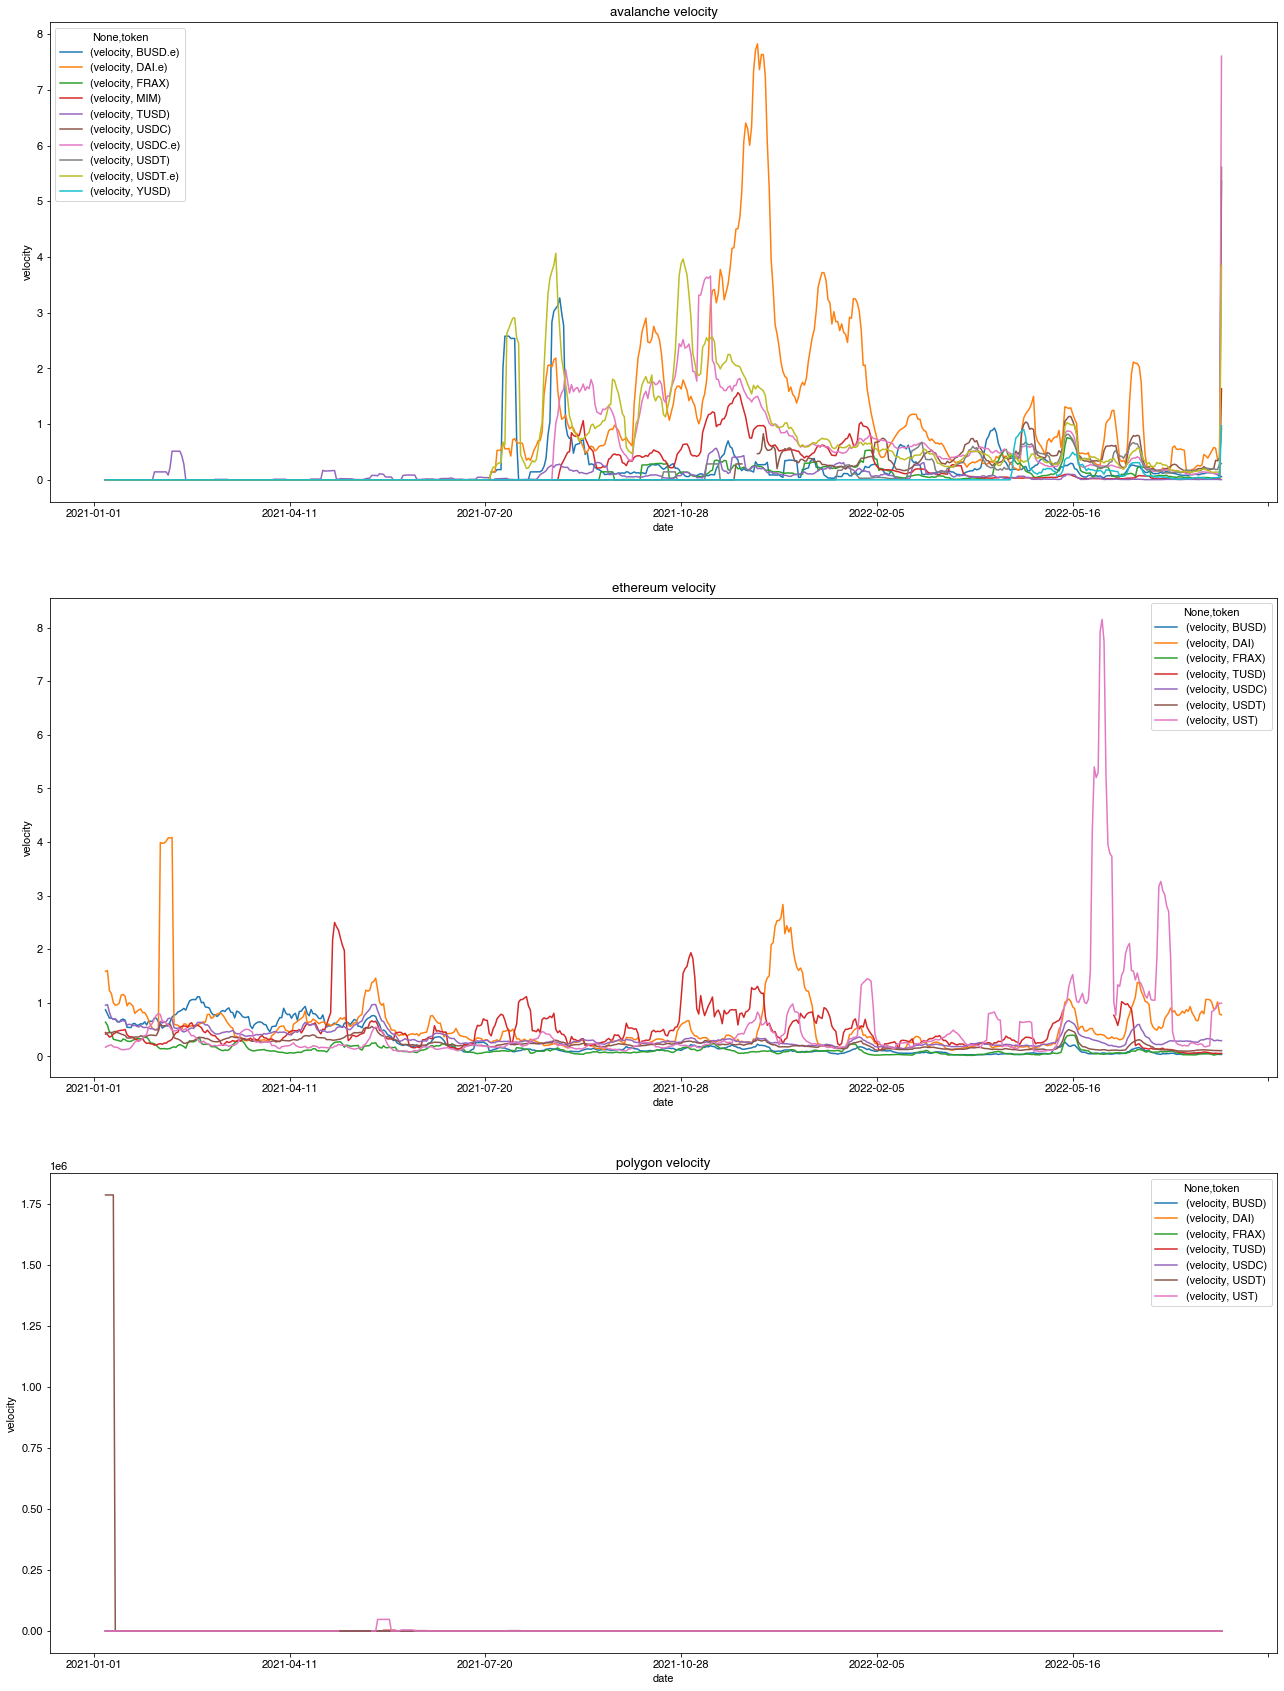

In [205]:
#Velocity
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(22,30))
subplots_vel = [ax1,ax2,ax3]
chains = ['avalanche','ethereum','polygon']
#fig = plt.figure(figsize=(22,8))
for k in range(3):
    curr_chain = chains[k]
    velocity_df = stable_df[stable_df['chain']==curr_chain] 
    velocity_df = velocity_df.groupby(['date','token'])['velocity'].sum().to_frame().unstack(level=1).abs() 
    velocity_df.rolling(7).mean().plot(ax = subplots_vel[k],title=curr_chain+' velocity',ylabel='velocity')

In [206]:
lend_df['borrows/deposits']=lend_df['totalBorrowBalanceUSD']/lend_df['totalDepositBalanceUSD']

<AxesSubplot:xlabel='date'>

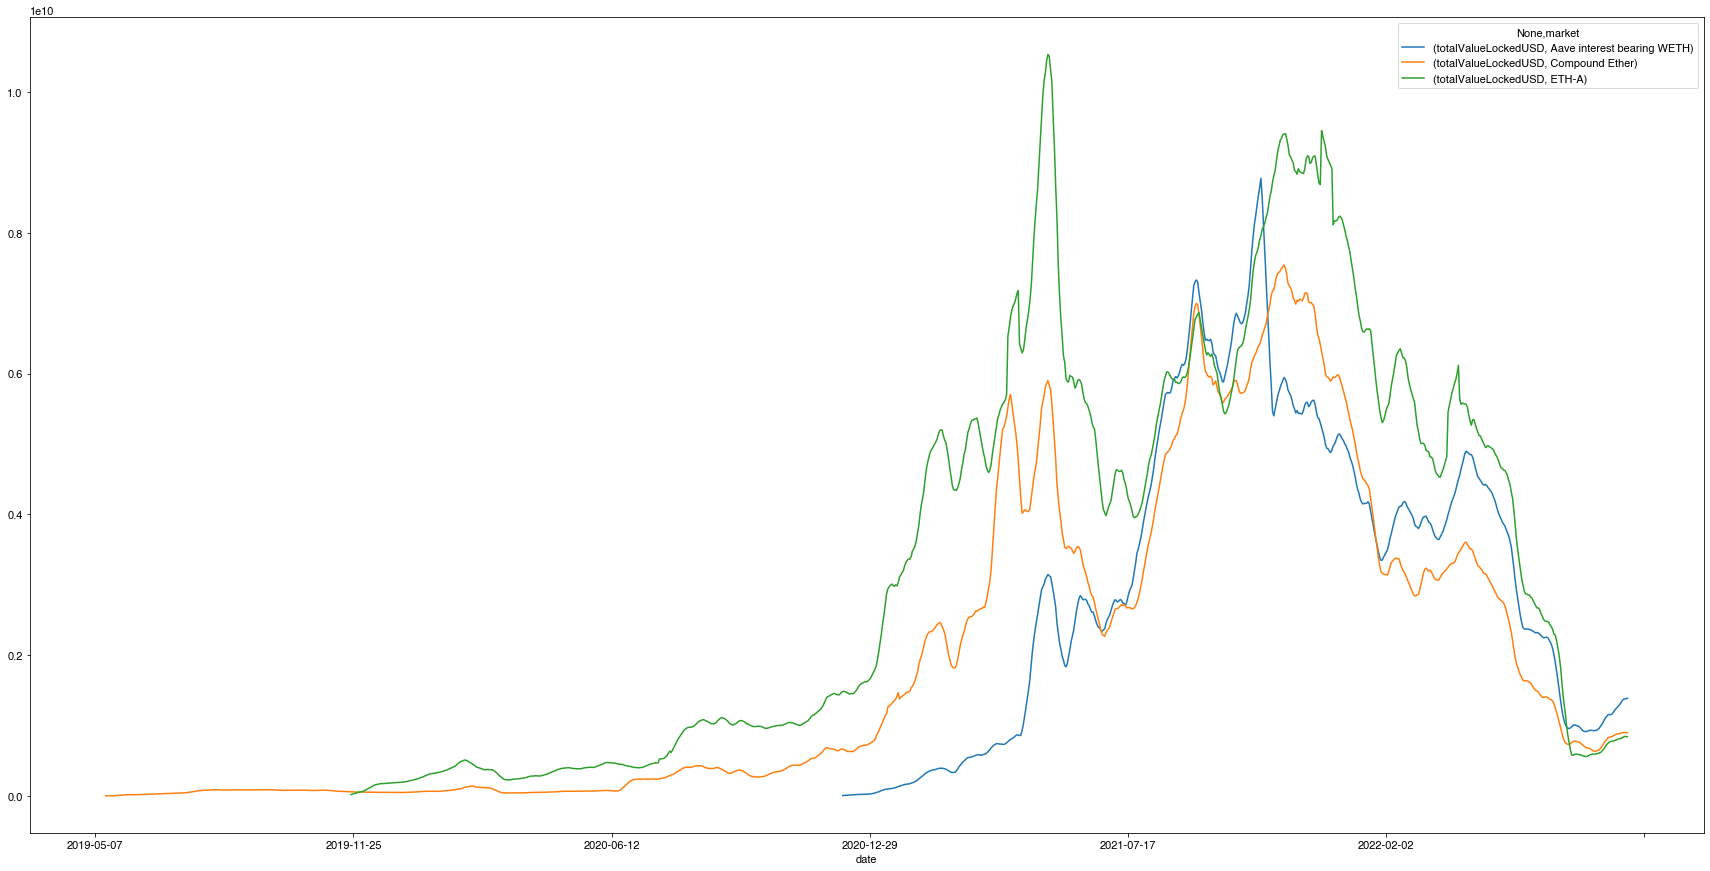

In [207]:
metric = 'totalValueLockedUSD'
curr_df = lend_df[(lend_df['chain']=='Ethereum') &
                 (lend_df[metric]>6e9)]
curr_df = curr_df.groupby(['date','market'])[metric].sum().to_frame().unstack(level=1).abs()
col_vals = curr_df.columns.values
top_markets = ['']*len(col_vals)
for k in range(len(col_vals)):
    top_markets[k] = col_vals[k][1]
curr_df = lend_df[lend_df['market'].isin(top_markets)]
curr_df = curr_df.groupby(['date','market'])[metric].sum().to_frame().unstack(level=1).abs()
curr_df.rolling(9).mean().plot(figsize=(30,15))

In [208]:
def plot_agg_lending(metric):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(22,30))
    fig 
    subplots = [ax1,ax2,ax3]
    chains = ['Avalanche','Ethereum','Polygon']
    for k in range(3):
        curr_chain=chains[k]
        curr_df = lend_df[(lend_df['chain']==curr_chain)]
        curr_df = curr_df.groupby(['date'])[metric].sum().to_frame().unstack(level=1).abs()
        curr_df.rolling(5).mean().plot(figsize=(30,30),ax=subplots[k],title = curr_chain+' '+metric)
        subplots[k].grid()

In [209]:
#plot_agg_lending('totalValueLockedUSD')

In [210]:
#plot_agg_lending('totalBorrowBalanceUSD')

In [211]:
#plot_agg_lending('borrows/deposits')

In [212]:
#plot_agg_lending('dailyTotalRevenueUSD')

In [213]:
def plot_agg_dex(metric):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(22,30))
    fig 
    subplots = [ax1,ax2,ax3]
    chains = ['Avalanche','Ethereum','Polygon']
    for k in range(3):
        curr_chain=chains[k]
        curr_df = dex_df[(dex_df['chain']==curr_chain)]
        curr_df = curr_df.groupby(['date'])[metric].sum().to_frame().unstack(level=1).abs()
        curr_df.rolling(5).mean().plot(figsize=(30,30),ax=subplots[k],title = curr_chain+' '+metric)
        subplots[k].grid()

In [214]:
#plot_agg_dex('TVL')

In [215]:
#plot_agg_stable('supply_ntv')

In [216]:
def plot_agg_dex():
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(22,30))
    fig 
    subplots = [ax1,ax2,ax3]
    metric_1 = 'TVL'
    metric_2 = 'supply_ntv'
    chains = ['Avalanche','Ethereum','Polygon']
    for k in range(3):
        curr_chain=chains[k]
        ax = subplots[k]
        curr_df = dex_df[(dex_df['chain']==curr_chain)]
        temp_df = stable_df[stable_df['chain']==curr_chain]
        curr_df = curr_df.groupby(['date'])[metric_1].sum().to_frame().unstack(level=1).abs()
        temp_df = temp_df.groupby(['date'])[metric_2].sum().to_frame().unstack(level=1).abs()
        curr_df.plot(figsize=(30,30),ax=ax,title = curr_chain+' '+metric_1)
        temp_df.plot(figsize=(30,30),ax=ax,title = curr_chain+' '+metric_2)
        subplots[k].grid()

In [217]:
def plot_TVLbySupply(start_dt, end_dt):
    tvl_supply_array = []
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(22,30))
    fig 
    subplots = [ax1,ax2,ax3]

    chains = ['Avalanche','Ethereum','Polygon']
    chain_prices = [avax_df, eth_df, matic_df]
    dfs = []

    for k in range(3):
        price_df = concat_data(chain_prices[k], start_dt, end_dt)
        fix_dates(price_df)
        
        curr_chain=chains[k]
        ax = subplots[k]

        tvl_df = dex_df[(dex_df['chain']==curr_chain)]
        tvl_df = tvl_df[(tvl_df['date'] >= start_dt) & (tvl_df['date'] <= end_dt)]
        tvl_df = tvl_df.groupby(['date'])['TVL'].sum().to_frame().abs()
        dfs.append(tvl_df)

        supply_df = stable_df[(stable_df['chain']==curr_chain.lower())]
        supply_df = supply_df[(supply_df['date'] >= start_dt) & (supply_df['date'] <= end_dt)]
        supply_df = supply_df.groupby(['date'])['supply_ntv'].sum().to_frame().abs()
        dfs.append(supply_df)

        tvl_supply = tvl_df
        tvl_supply['supply'] = supply_df.supply_ntv
        tvl_supply['tvl/supply'] = tvl_df['TVL']/tvl_df['supply']
        tvl_supply = tvl_supply.reset_index()
        tvl_supply['price'] = price_df['price'] #Add token prices
        tvl_supply_array.append(tvl_supply)
        
        tvl_supply['date'] = pd.to_datetime(tvl_supply['date'])
        #tvl_supply['date']=tvl_supply['date'].map(datetime.toordinal)

        ROLLING_MEAN_LENGTH = 5
        
        ax_second_axis = ax.twinx()
        
        ax.plot(tvl_supply['date'],tvl_supply['tvl/supply'].rolling(9).mean())
        ax.set_title(curr_chain+ ' TVL/Supply | mean = '+str(round(tvl_supply['tvl/supply'].mean(),3)))
        ax.legend(['TVL/Supply'],loc = 'upper left')
        
        ax_second_axis.plot(tvl_supply['date'],tvl_supply['TVL'].rolling(9).mean(), color = 'red')
        ax_second_axis.legend(['TVL'],loc = 'upper right')
        
        #data = tvl_supply
        #X = data.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
        #Y = data.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
        #linear_regressor = LinearRegression()  # create object for the class
        #linear_regressor.fit(X, Y)  # perform linear regression
        #Y_pred = linear_regressor.predict(X)  # make predictions
        #ax.plot(X, Y_pred, color='green')

        
        #tvl_supply['price'].rolling(ROLLING_MEAN_LENGTH).mean().plot(x = 'date',y = 'price',ax=ax_second_axis, color = 'red', ylabel = 'Price ($)')
        #ax_second_axis.legend(['Price'],loc = 'upper right')
        
        #df = tvl_supply
        #df['min'] = df.price.rolling(ROLLING_MEAN_LENGTH).mean()[(df.price.shift(1) > df.price) & (df.price.shift(-1) > df.price)]
        #df['max'] = df.price.rolling(ROLLING_MEAN_LENGTH).mean()[(df.price.shift(1) < df.price) & (df.price.shift(-1) < df.price)]
        
        #ax_second_axis.scatter(df.index, df['min'], c='r')
        #ax_second_axis.scatter(df.index, df['max'], c='g')
        
#        ax2.legend(loc='upper right')        
        subplots[k].grid()

    return tvl_supply_array

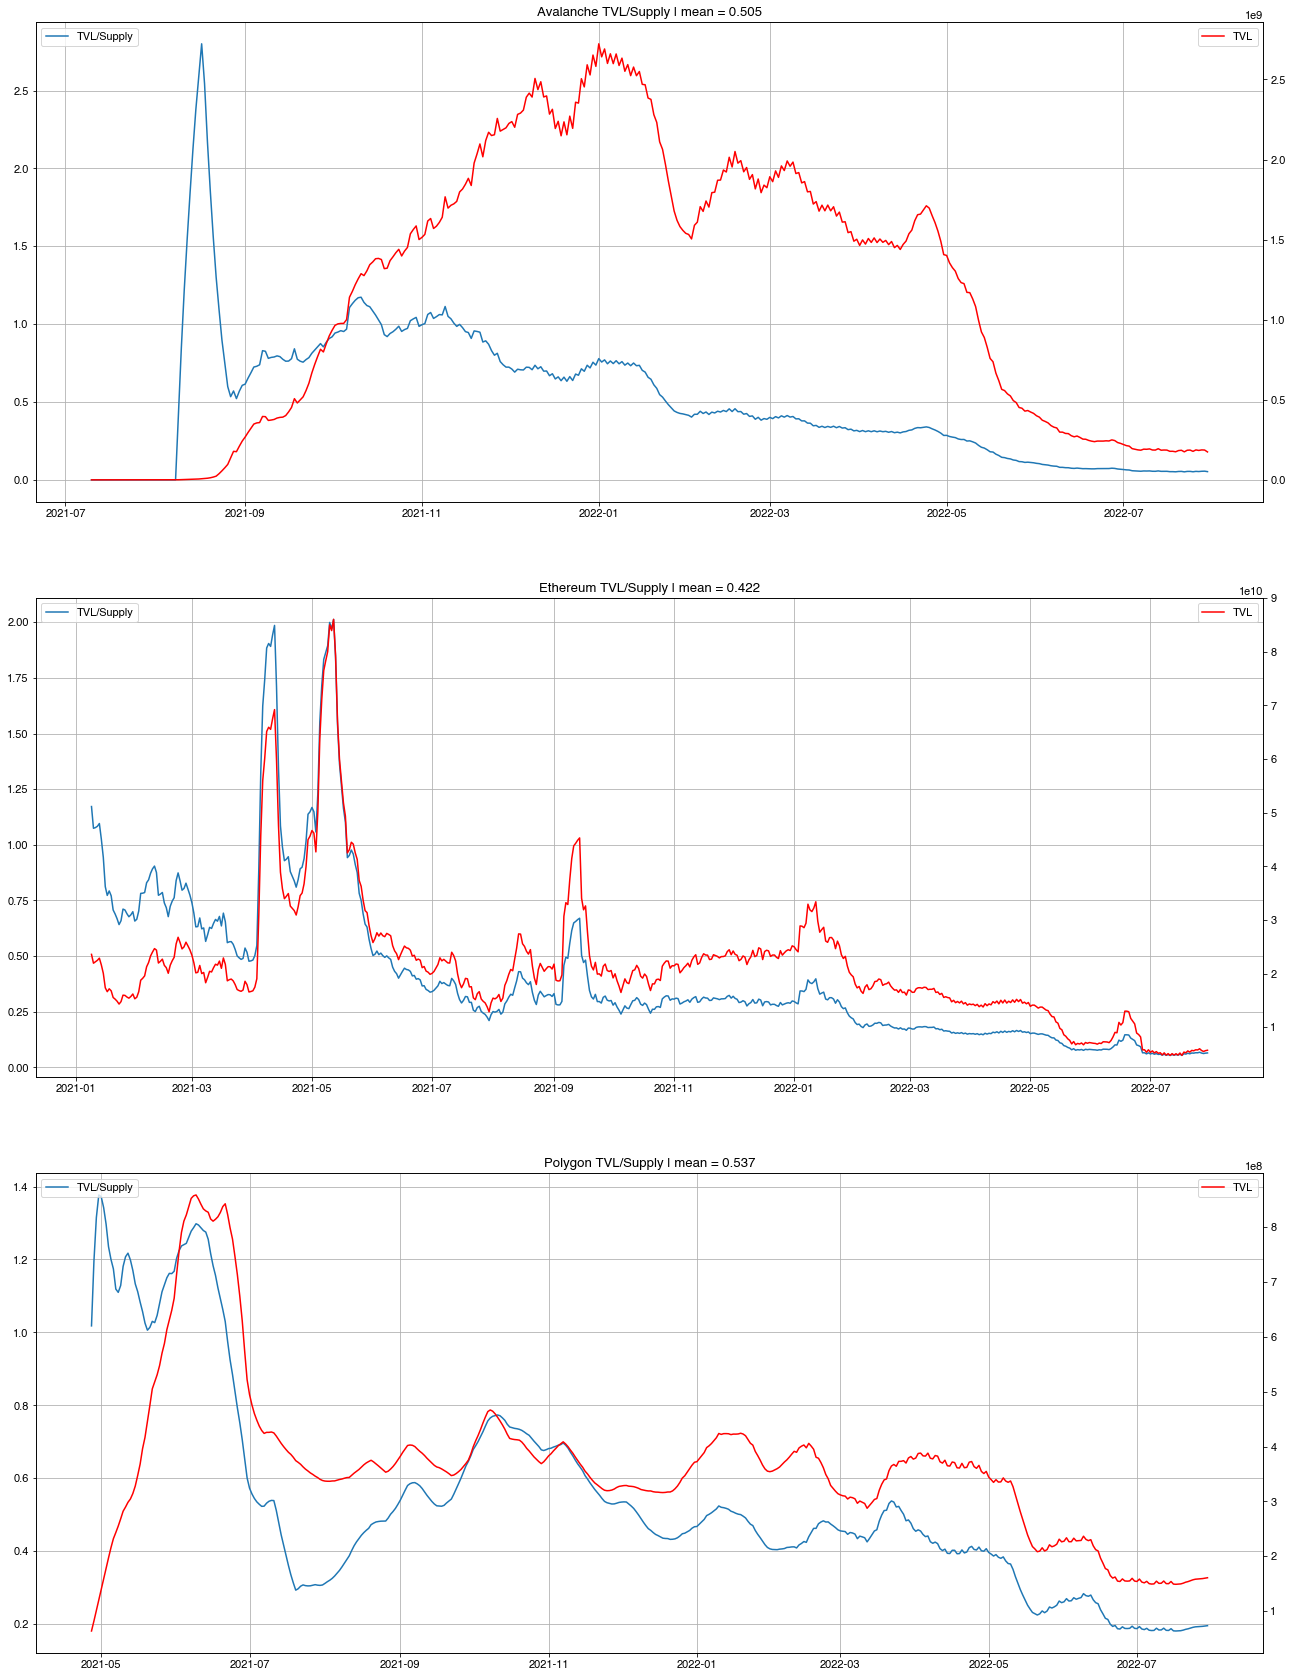

In [218]:
tvl_supply_array = plot_TVLbySupply('2021-01-01', '2022-07-30')

In [219]:
def plot_TVLbySupply(start_dt, end_dt):
    tvl_supply_array = []
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(22,30))
    fig 
    subplots = [ax1,ax2,ax3]

    chains = ['Avalanche','Ethereum','Polygon']
    chain_prices = [avax_df, eth_df, matic_df]
    dfs = []

    for k in range(3):
        price_df = concat_data(chain_prices[k], start_dt, end_dt)
        fix_dates(price_df)
        
        curr_chain=chains[k]
        ax = subplots[k]

        tvl_df = dex_df[(dex_df['chain']==curr_chain)]
        tvl_df = tvl_df[(tvl_df['date'] >= start_dt) & (tvl_df['date'] <= end_dt)]
        tvl_df = tvl_df.groupby(['date'])['TVL'].sum().to_frame().abs()
        dfs.append(tvl_df)

        supply_df = stable_df[(stable_df['chain']==curr_chain.lower())]
        supply_df = supply_df[(supply_df['date'] >= start_dt) & (supply_df['date'] <= end_dt)]
        supply_df = supply_df.groupby(['date'])['supply_ntv'].sum().to_frame().abs()
        dfs.append(supply_df)

        tvl_supply = tvl_df
        tvl_supply['supply'] = supply_df.supply_ntv
        tvl_supply['tvl/supply'] = tvl_df['TVL']/tvl_df['supply']
        tvl_supply = tvl_supply.reset_index()
        tvl_supply['price'] = price_df['price'] #Add token prices
        tvl_supply_array.append(tvl_supply)
        
        tvl_supply['date'] = pd.to_datetime(tvl_supply['date'])
        tvl_supply['date']=tvl_supply['date'].map(datetime.toordinal)

        ROLLING_MEAN_LENGTH = 5
        
        
        
        ax.plot(tvl_supply['date'],tvl_supply['tvl/supply'].rolling(9).mean())
        ax.set_title(curr_chain+ ' TVL/Supply | mean = '+str(round(tvl_supply['tvl/supply'].mean(),3)))
        ax.legend(['TVL/Supply'],loc = 'upper left')
        
        #ax_second_axis = ax.twinx()
        #ax_second_axis.plot(tvl_supply['date'],tvl_supply['TVL'].rolling(9).mean(), color = 'red')
        #ax_second_axis.legend(['TVL'],loc = 'upper right')
        
        data = tvl_supply
        X = data.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
        Y = data.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
        linear_regressor = LinearRegression()  # create object for the class
        linear_regressor.fit(X, Y)  # perform linear regression
        Y_pred = linear_regressor.predict(X)  # make predictions
        ax.plot(X, Y_pred, color='green')

        
        #tvl_supply['price'].rolling(ROLLING_MEAN_LENGTH).mean().plot(x = 'date',y = 'price',ax=ax_second_axis, color = 'red', ylabel = 'Price ($)')
        #ax_second_axis.legend(['Price'],loc = 'upper right')
        
        #df = tvl_supply
        #df['min'] = df.price.rolling(ROLLING_MEAN_LENGTH).mean()[(df.price.shift(1) > df.price) & (df.price.shift(-1) > df.price)]
        #df['max'] = df.price.rolling(ROLLING_MEAN_LENGTH).mean()[(df.price.shift(1) < df.price) & (df.price.shift(-1) < df.price)]
        
        #ax_second_axis.scatter(df.index, df['min'], c='r')
        #ax_second_axis.scatter(df.index, df['max'], c='g')
        
#        ax2.legend(loc='upper right')        
        subplots[k].grid()

        judgement_day = datetime.strptime("2024-01-01", "%Y-%m-%d").toordinal()
        mula = linear_regressor.coef_ * judgement_day + linear_regressor.intercept_
        print(curr_chain + ': y = '+ str(linear_regressor.coef_)+'x + '+str(linear_regressor.intercept_))
        print("TVL/Supply on Jan 2024" + str(mula))

    return tvl_supply_array

Avalanche: y = [[-0.00201046]]x + [1484.56301391]
TVL/Supply on Jan 2024[[-0.93506687]]
Ethereum: y = [[-0.00167218]]x + [1234.6252944]
TVL/Supply on Jan 2024[[-0.92854611]]
Polygon: y = [[-0.00158811]]x + [1172.7738942]
TVL/Supply on Jan 2024[[-0.65959311]]


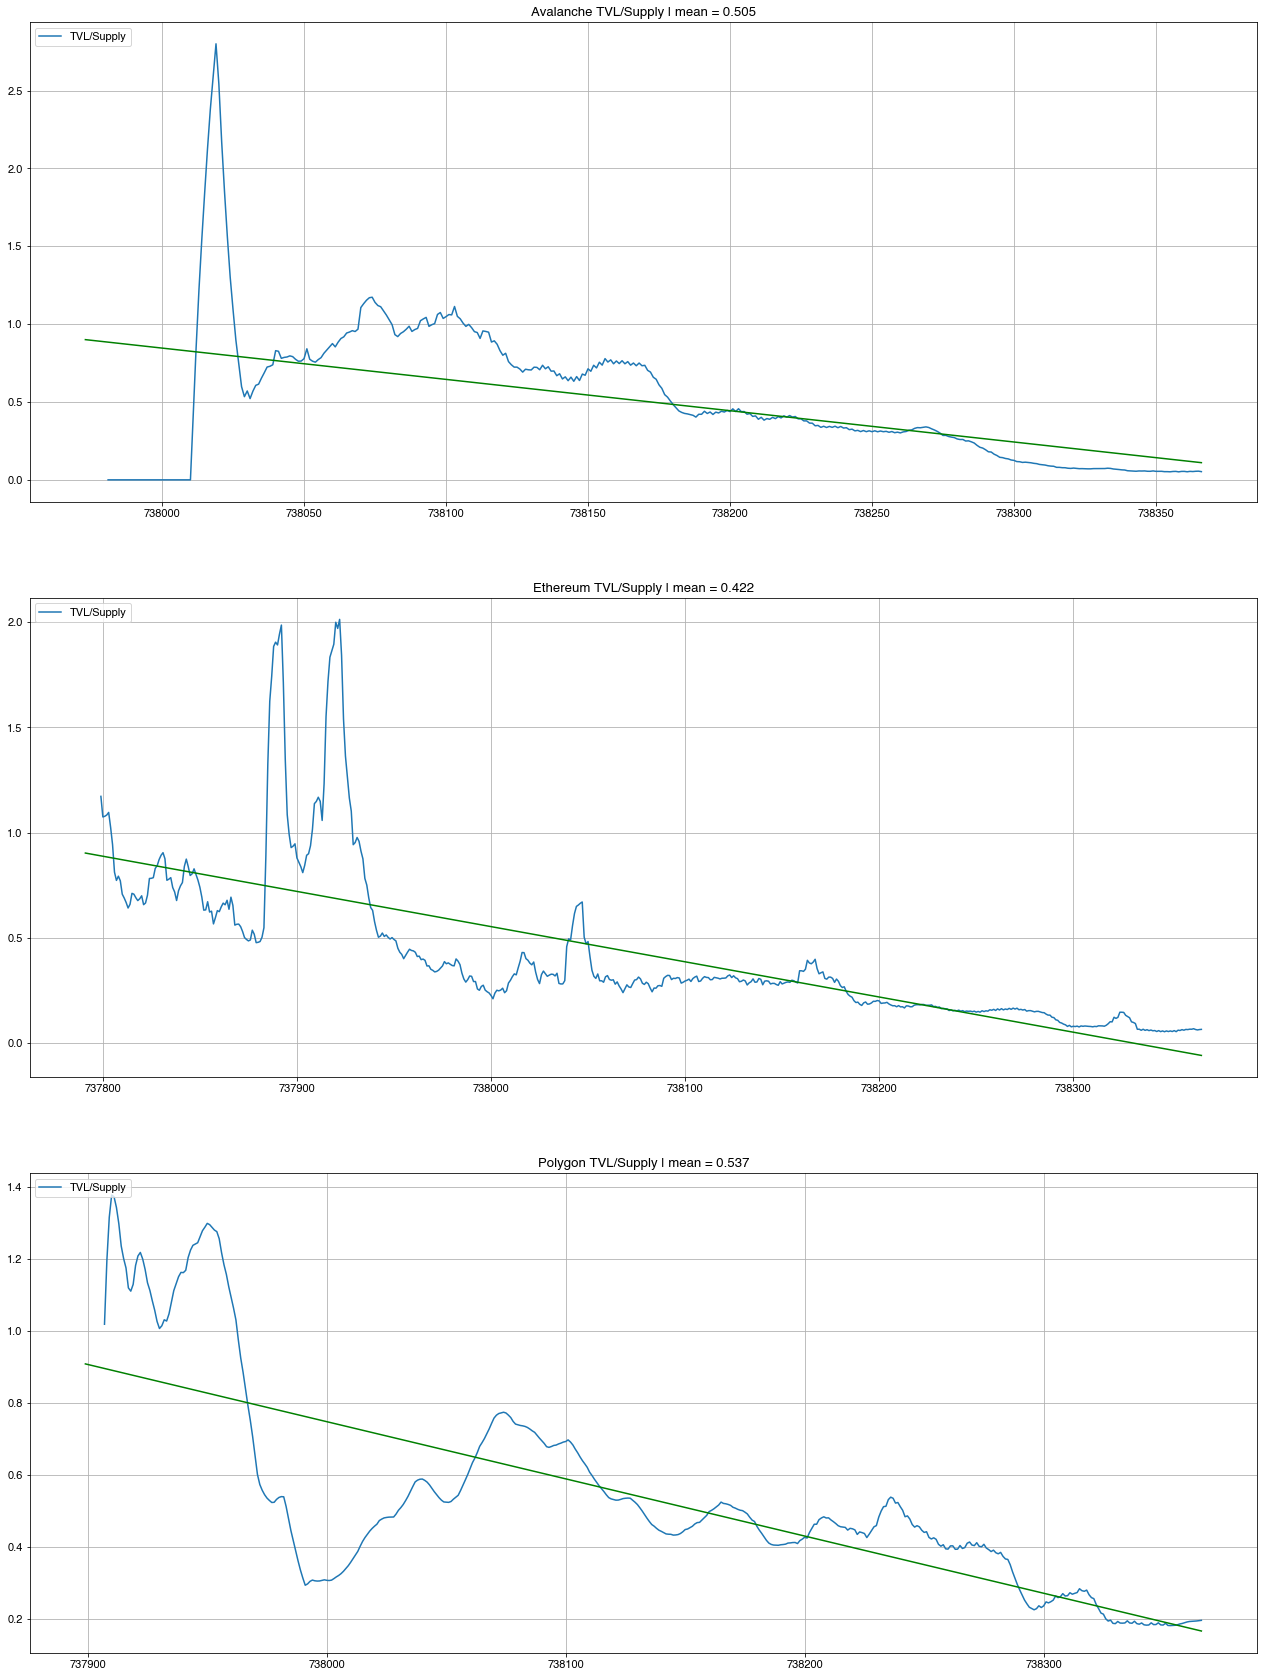

In [220]:
tvl_supply_array = plot_TVLbySupply('2021-01-01', '2022-07-30')

In [221]:
def get_price(coin):
    dates = pd.date_range(start='2021-01-01', end='2022-07-31')
    price = [0.00]*len(dates)
    
    for k in range(len(dates)):
        data = cg.get_coin_history_by_id(id=coin,date=dates[k].strftime("%d-%m-%Y"), localization='false', vs_currency = 'usd')
        price[k] = data['market_data']['current_price']['usd']
        time.sleep(0.9)
    df = pd.DataFrame({'date':dates, 'price':price})
    return df

In [222]:
tvl_supply_array[0]

,date,TVL,supply,tvl/supply,price
0,737973,0.000000e+00,5.947310e+05,0.000000,3.206777
1,737974,0.000000e+00,5.947310e+05,0.000000,3.665840
2,737975,0.000000e+00,5.947310e+05,0.000000,3.501131
3,737976,0.000000e+00,5.947310e+05,0.000000,3.460422
4,737977,0.000000e+00,5.925535e+05,0.000000,3.515633
...,...,...,...,...,...
389,738362,1.974878e+08,3.443513e+09,0.057351,63.031441
390,738363,1.820568e+08,3.470263e+09,0.052462,68.148857
391,738364,2.062503e+08,3.066535e+09,0.067258,66.139206
392,738365,2.045010e+08,3.022972e+09,0.067649,64.837427


In [223]:
test_pool = dex_df[(dex_df['protocol']=='Trader Joe')& (dex_df['pool_name']=='USDC.e/WAVAX') & (dex_df['chain']=='Avalanche') & (dex_df['protocol_version']=='V1')]

test_pool = test_pool.drop_duplicates(subset=['date', 'pool_name'], keep='first')
test_pool = concat_data(test_pool, '2021-05-04', '2022-07-30')

pool_price = concat_data(avax_df, '2021-05-04', '2022-07-31') #TODO: Fix this date error
fix_dates(pool_price)

test_pool['date'] = pd.to_datetime(test_pool['date'])
test_pool['date'] = test_pool.date.dt.date
test_pool['date'] = pd.to_datetime(test_pool['date'])

pool_price['date'] = pd.to_datetime(pool_price['date'])
pool_price['date'] = pool_price.date.dt.date
pool_price['date'] = pd.to_datetime(pool_price['date'])

pool_price = pool_price.set_index('date')
test_pool = test_pool.set_index('date')



In [224]:
combined = pd.concat([pool_price, test_pool], axis=1)
combined['token_2_value_USD'] = combined['token_2_balance']*combined['price']
combined['token_1_value_USD'] = combined['token_1_balance']
combined['%1'] = combined['token_1_value_USD']/combined['TVL']
combined = combined.reset_index()

/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/1108188874.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_pool['date'] = pd.to_datetime(curr_pool['date'])
/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/1108188874.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_token['date'] = date_array


0.03829521118374427


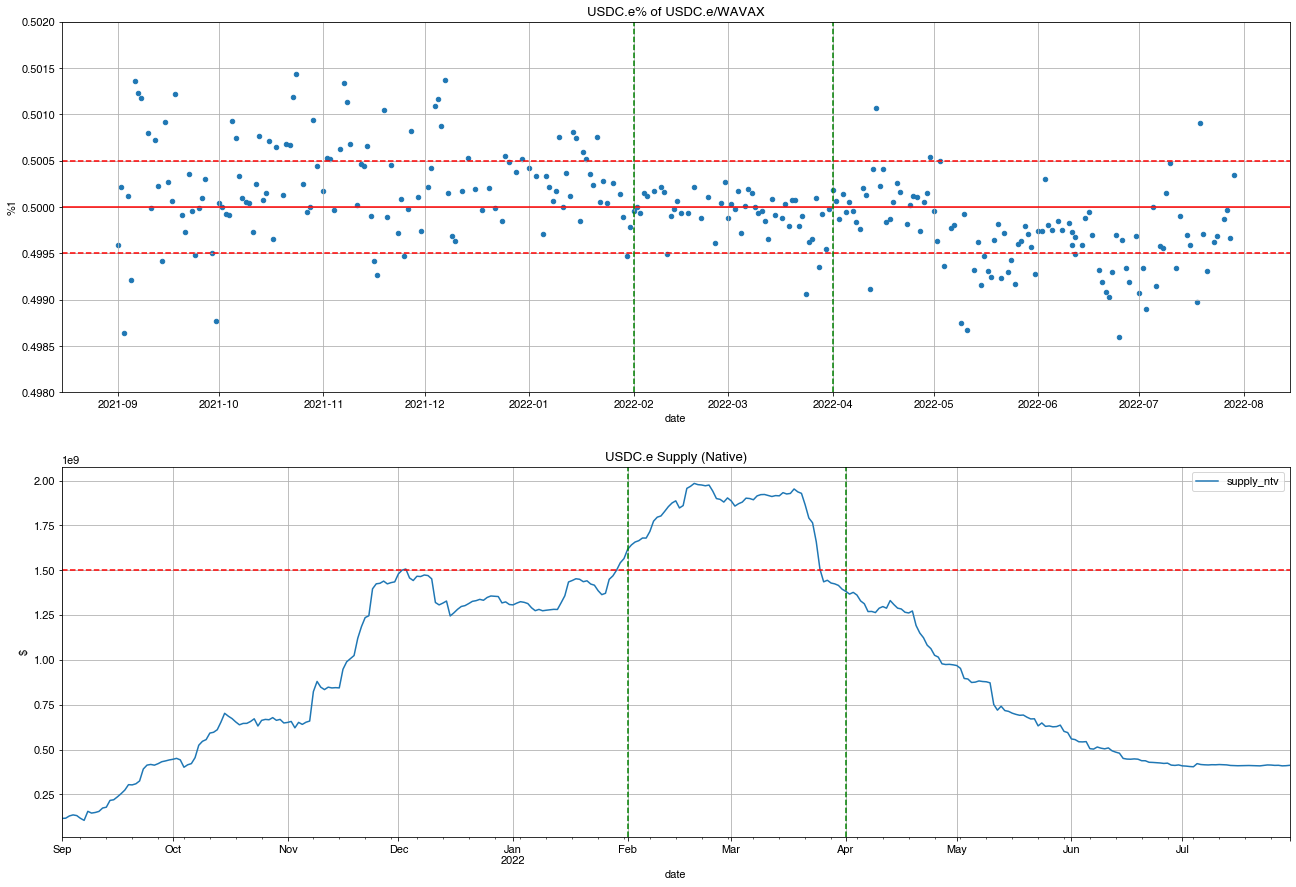

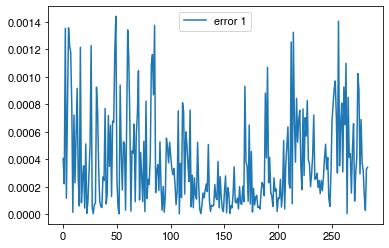

In [225]:
curr_pool = dex_df[(dex_df['protocol']=='Trader Joe')& 
                   (dex_df['pool_name']=='USDC.e/WAVAX') & 
                   (dex_df['chain']=='Avalanche') & 
                   (dex_df['protocol_version']=='V1')]

start_dt = '2021-09-01'
end_dt = '2022-07-30'

curr_pool['date'] = pd.to_datetime(curr_pool['date'])
curr_pool = concat_data(curr_pool, start_dt, end_dt)
curr_pool['date'] = curr_pool.date.dt.date
#curr_pool = curr_pool.dropna()
#print(curr_pool)

token_1 = curr_pool['token_1'].iloc[100]
token_2 = curr_pool['token_2'].iloc[100]

curr_token = stable_df.loc[(stable_df['token']==token_1)]
date_array = pd.date_range('2021-01-01', '2022-07-31')
#date_array = date_array.map(lambda t: t.strftime('%Y-%m-%d'))
curr_token['date'] = date_array
#curr_token = curr_token.dropna()
curr_token = concat_data(curr_token, start_dt, end_dt)

fig, (ax1, ax2) = plt.subplots(2, figsize = (22,30))

curr_pool.plot.scatter(x = 'date', y= '%1', ax = ax1, ylim = [0.498,0.502], figsize = (22,15), title = (token_1 + "% of "+ token_1 + '/' + token_2))
ax1.axhline(y = 0.5, color = 'r', linestyle = '-')
ax1.axhline(y = 0.5005, color = 'r', linestyle = '--')
ax1.axhline(y = 0.4995, color = 'r', linestyle = '--')
ax1.axvline(x = datetime(2022,2,1), color = 'g', linestyle = '--')
ax1.axvline(x = datetime(2022,4,1), color = 'g', linestyle = '--')
ax1.grid()
#start_date = datetime(2021, 3, 2)
#end_date = datetime(2021, 3, 5)
#ax1.set_xlim([start_dt, end_dt])
curr_token.plot(x = 'date', y = 'supply_ntv', figsize = (22,15), ax = ax2, title = token_1 + ' Supply (Native)', ylabel = '$')
ax2.grid()
ax2.axvline(x = datetime(2022,4,1), color = 'g', linestyle = '--')
ax2.axvline(x = datetime(2022,2,1), color = 'g', linestyle = '--')
ax2.axhline(y = 1.5e9, color = 'r', linestyle = '--')
curr_pool.plot(y='error 1')
print(np.mean(curr_pool['error 1']*100))

/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/1500626932.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_pool['date'] = pd.to_datetime(curr_pool['date'])


0.029642229749564614
0.03833654333574389


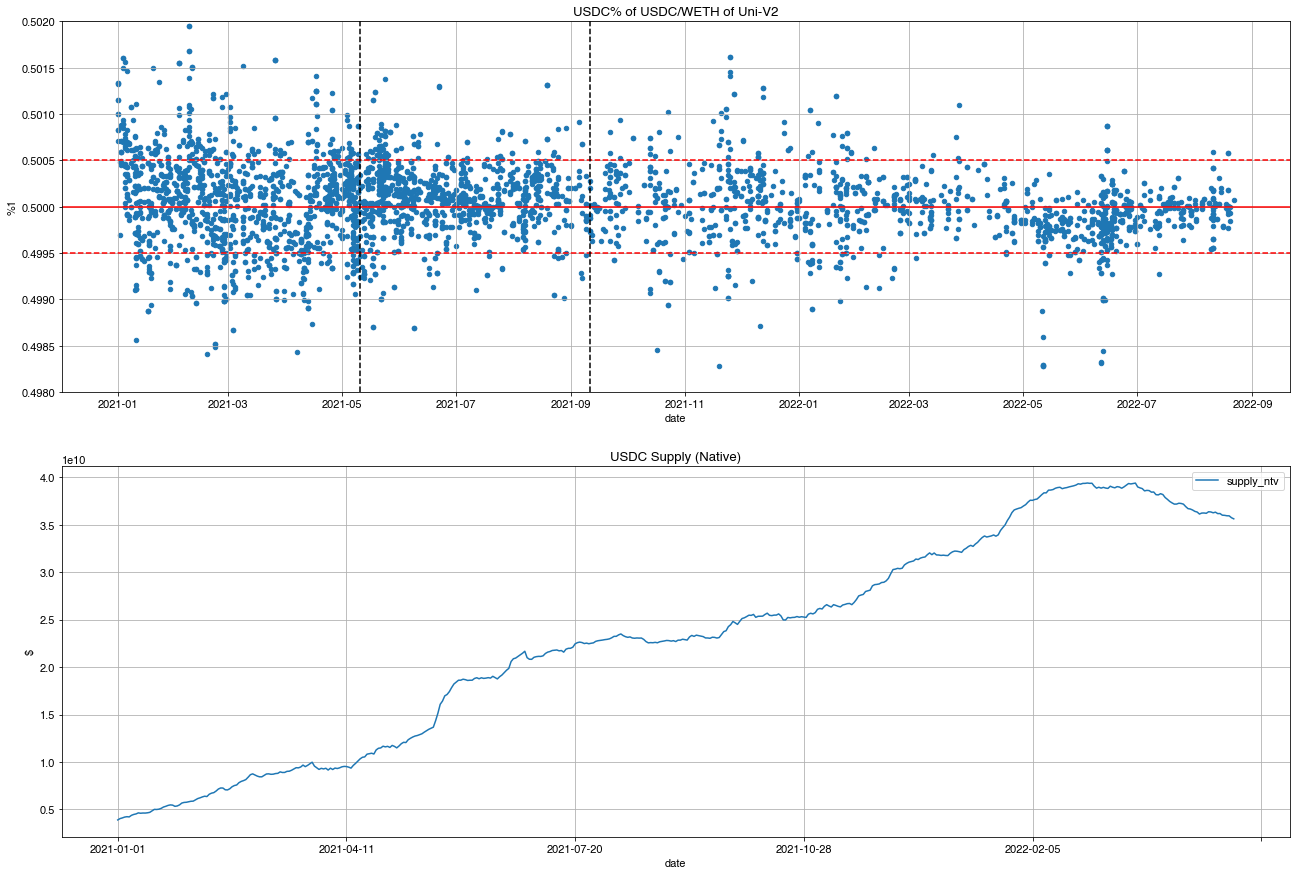

In [226]:
curr_pool = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='USDC/WETH') & 
                   (dex_df['chain']=='Ethereum') & 
                   (dex_df['%1']<1)&
                   (dex_df['%1']>0)&
                   (dex_df['protocol_version']=='V2')]

curr_pool.drop_duplicates(subset=['date'])

start_dt = '2021-01-01'
end_dt = '2022-05-04'

curr_pool['date'] = pd.to_datetime(curr_pool['date'])

#curr_pool = concat_data(curr_pool, start_dt, end_dt)
#curr_pool['date'] = curr_pool.date.dt.date
#curr_pool = curr_pool.dropna()
#print(curr_pool)

token_1 = curr_pool['token_1'].iloc[100]
token_2 = curr_pool['token_2'].iloc[100]
chain = curr_pool['chain'].iloc[100]

curr_token = stable_df.loc[(stable_df['token']==token_1)
                          & (stable_df['chain']==chain.lower())]
#date_array = pd.date_range('2021-01-01', '2022-07-31')
#date_array = date_array.map(lambda t: t.strftime('%Y-%m-%d'))
#curr_token['date'] = date_array
#curr_token = curr_token.dropna()
curr_token = concat_data(curr_token, start_dt, end_dt)

fig, (ax1, ax2) = plt.subplots(2, figsize = (22,30))

curr_pool.plot.scatter(x = 'date', y= '%1', ax = ax1, ylim = [0.498,0.502], figsize = (22,15), title = (token_1 + "% of "+ token_1 + '/' + token_2 + ' of Uni-V2'))
ax1.axhline(y = 0.5, color = 'r', linestyle = '-')
ax1.axhline(y = 0.5005, color = 'r', linestyle = '--')
ax1.axhline(y = 0.4995, color = 'r', linestyle = '--')
ax1.axvline(x = datetime(2021,5,11), color = 'black', linestyle = '--')
ax1.axvline(x = datetime(2021,9,11), color = 'black', linestyle = '--')
#ax1.axvline(x = datetime(2022,4,1), color = 'g', linestyle = '--')
ax1.grid()
#start_date = datetime(2021, 3, 2)
#end_date = datetime(2021, 3, 5)
#ax1.set_xlim([start_dt, end_dt])
curr_token.plot(x = 'date', y = 'supply_ntv', figsize = (22,15), ax = ax2, title = token_1 + ' Supply (Native)', ylabel = '$')
ax2.grid()


range_mean = curr_pool[(curr_pool['date']>'2021-09-20')& (curr_pool['date']<'2021-10-10')]
mean = np.mean(range_mean['error 1'])
overall_error = np.mean(curr_pool['error 1'])
print(mean*100)
print(overall_error*100)
#ax2.axvline(x = datetime(2022,4,1), color = 'g', linestyle = '--')
#ax2.axvline(x = datetime(2022,2,1), color = 'g', linestyle = '--')
#ax2.axhline(y = 1.5e9, color = 'r', linestyle = '--')

/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/49605591.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_pool['date'] = pd.to_datetime(curr_pool['date'])
/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/49605591.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_pool['MA'] = curr_pool['%1'].rolling(30).mean()


0.11818459611071092


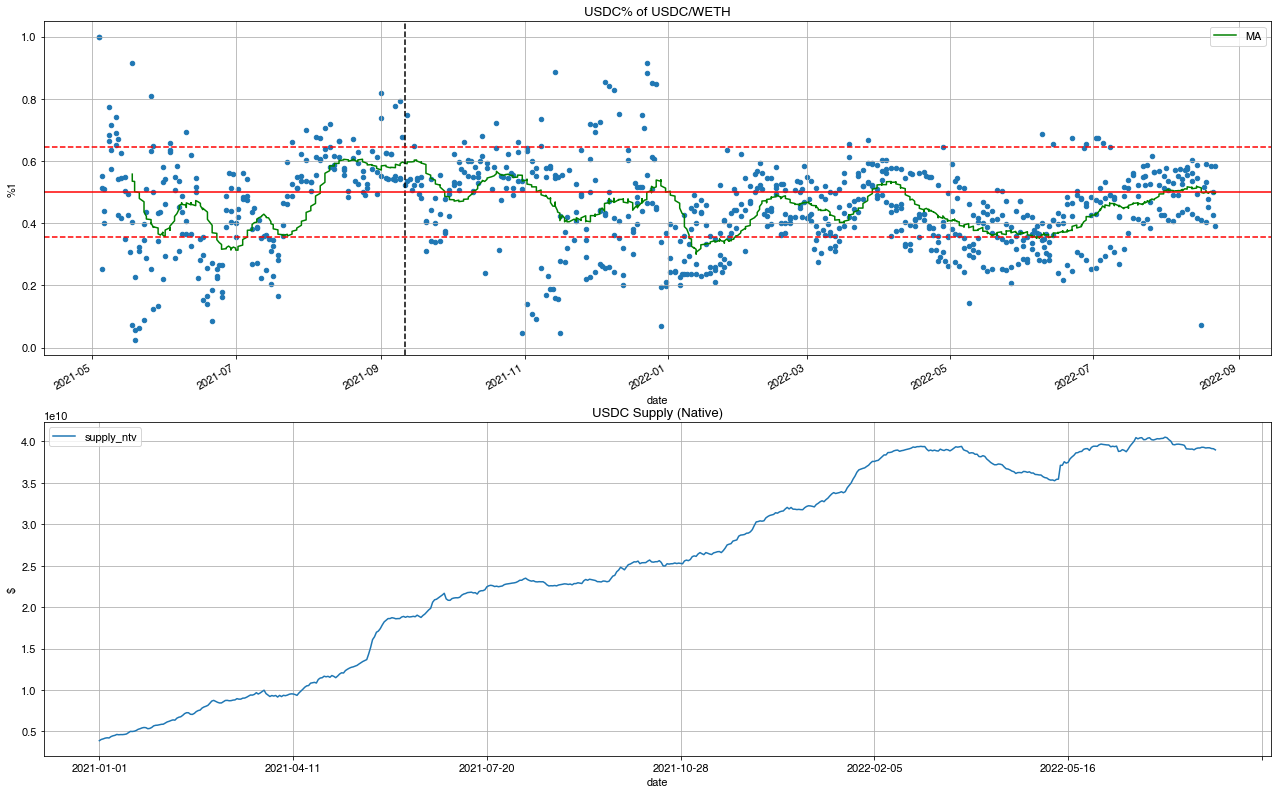

In [227]:
curr_pool = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='USDC/WETH') & 
                   (dex_df['chain']=='Ethereum') & 
                   (dex_df['protocol_version']=='V3')]

start_dt = '2021-01-01'
end_dt = '2022-07-31'

curr_pool['date'] = pd.to_datetime(curr_pool['date'])
error_std = np.std(curr_pool['%1'])

token_1 = curr_pool['token_1'].iloc[50]
token_2 = curr_pool['token_2'].iloc[50]
chain = curr_pool['chain'].iloc[50]

curr_token = stable_df.loc[(stable_df['token']==token_1)
                          & (stable_df['chain']==chain.lower())]

curr_token = concat_data(curr_token, start_dt, end_dt)

fig, (ax1, ax2) = plt.subplots(2, figsize = (22,30))

curr_pool.plot.scatter(x = 'date', y= '%1', ax = ax1,  figsize = (22,15), title = (token_1 + "% of "+ token_1 + '/' + token_2))
curr_pool['MA'] = curr_pool['%1'].rolling(30).mean()
curr_pool.plot(x = 'date', y= 'MA', ax = ax1, c = 'g')

#ax1.axvline(x = datetime(2021,5,11), color = 'black', linestyle = '--')
ax1.axvline(x = datetime(2021,9,11), color = 'black', linestyle = '--')

ax1.axhline(y = 0.5, color = 'r', linestyle = '-')
ax1.axhline(y = 0.5+error_std, color = 'r', linestyle = '--')
ax1.axhline(y = 0.5-error_std, color = 'r', linestyle = '--')

ax1.grid()

curr_token.plot(x = 'date', y = 'supply_ntv', figsize = (22,15), ax = ax2, title = token_1 + ' Supply (Native)', ylabel = '$')
ax2.grid()
print(np.mean(curr_pool['error 1']))


/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/2708398070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_concat['date'] = pd.to_datetime(eth_concat['date'])


Text(0.5, 1.0, 'Uniswap V3 USDC Share of USDC/WETH vs ETH Price')

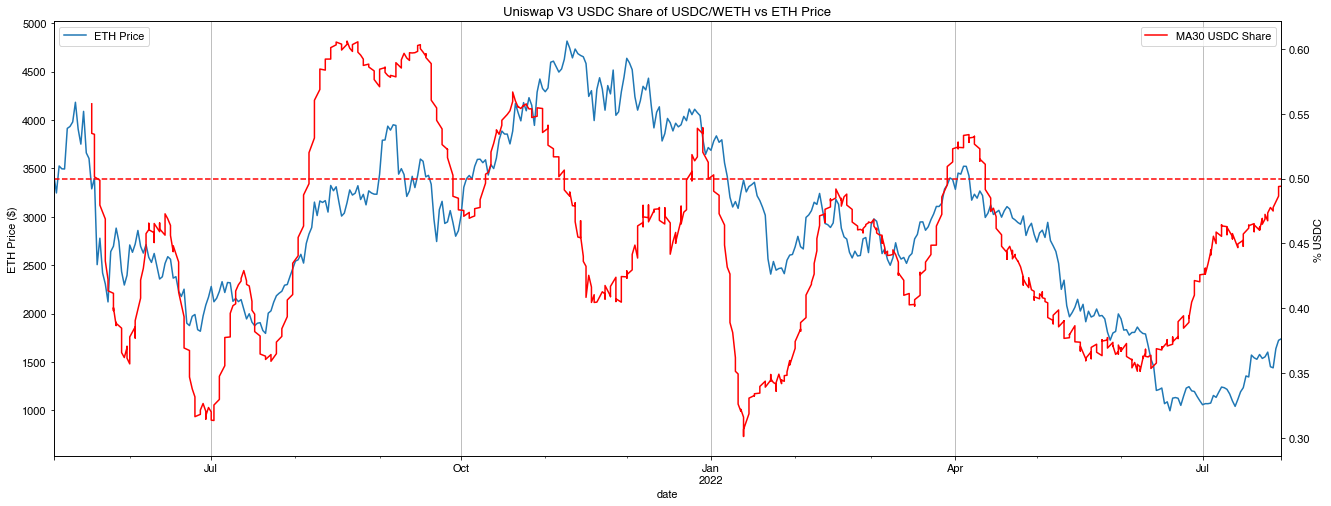

In [228]:
fig , ax = plt.subplots()
eth_concat = eth_df[(eth_df['date']>'2021-01-01')& (eth_df['date']<'2022-07-31')]
eth_concat['date'] = pd.to_datetime(eth_concat['date'])
eth_concat.plot(x='date', y='price', figsize = (22,8), ax=ax)
ax.legend(['ETH Price'], loc = 'upper left')
ax.set_ylabel('ETH Price ($)')
ax2 = ax.twinx()

curr_pool = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='USDC/WETH') & 
                   (dex_df['chain']=='Ethereum') & 
                   (dex_df['protocol_version']=='V3')]

curr_pool = curr_pool[(curr_pool['date']>'2021-01-01')& (curr_pool['date']<'2022-07-31')]
#curr_pool = curr_pool.drop_duplicates(subset=['date'], keep = 'first')

curr_pool['date'] = pd.to_datetime(curr_pool['date'])
curr_pool['MA9'] = curr_pool['%1'].rolling(30).mean()
curr_pool.plot(x='date', y='MA9', ax = ax2, color = 'red')
ax2.set_ylabel('% USDC')
ax2.axhline(y = 0.5, color = 'r', linestyle = '--')
ax2.legend(['MA30 USDC Share'])

ax.xaxis.grid()
ax.set_title('Uniswap V3 USDC Share of USDC/WETH vs ETH Price')

/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/2735989118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_concat['date'] = pd.to_datetime(eth_concat['date'])


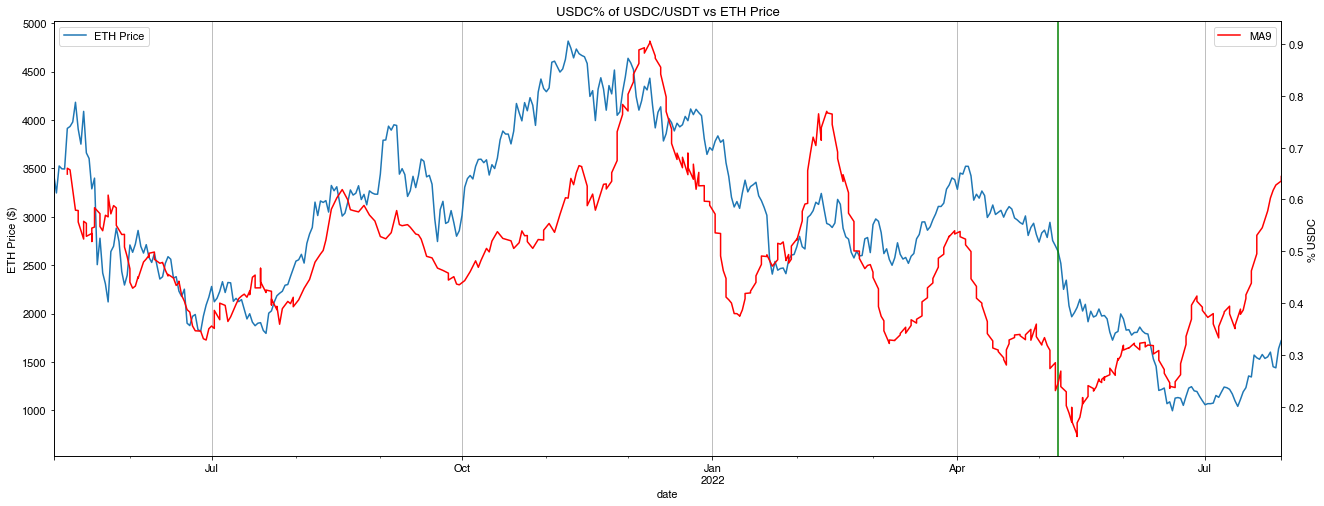

In [229]:
fig , ax = plt.subplots()
eth_concat = eth_df[(eth_df['date']>'2021-01-01')& (eth_df['date']<'2022-07-31')]
eth_concat['date'] = pd.to_datetime(eth_concat['date'])
eth_concat.plot(x='date', y='price', figsize = (22,8), ax=ax)
ax.legend(['ETH Price'], loc = 'upper left')
ax.set_ylabel('ETH Price ($)')
ax2 = ax.twinx()

curr_pool = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='USDC/USDT') & 
                   (dex_df['chain']=='Ethereum') & 
                   (dex_df['protocol_version']=='V3')]

token_1 = curr_pool['token_1'].iloc[50]
token_2 = curr_pool['token_2'].iloc[50]
chain = curr_pool['chain'].iloc[50]

curr_pool = curr_pool[(curr_pool['date']>'2021-01-01')& (curr_pool['date']<'2022-07-31')]
#curr_pool = curr_pool.drop_duplicates(subset=['date'], keep = 'first')

curr_pool['date'] = pd.to_datetime(curr_pool['date'])
curr_pool['MA9'] = curr_pool['%1'].rolling(9).mean()
curr_pool.plot(x='date', y='MA9', ax = ax2, color = 'red')
ax2.set_ylabel('% USDC')

ax.xaxis.grid()
ax.set_title(token_1 + "% of "+ token_1 + '/' + token_2 + ' vs ETH Price')
ax.axvline(x = '2022-05-08', color = 'g', linestyle = '-')

/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/3008662092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_concat['date'] = pd.to_datetime(eth_concat['date'])


Text(0.5, 1.0, 'Uniswap V3 DAI Share of DAI/WETH vs ETH Price')

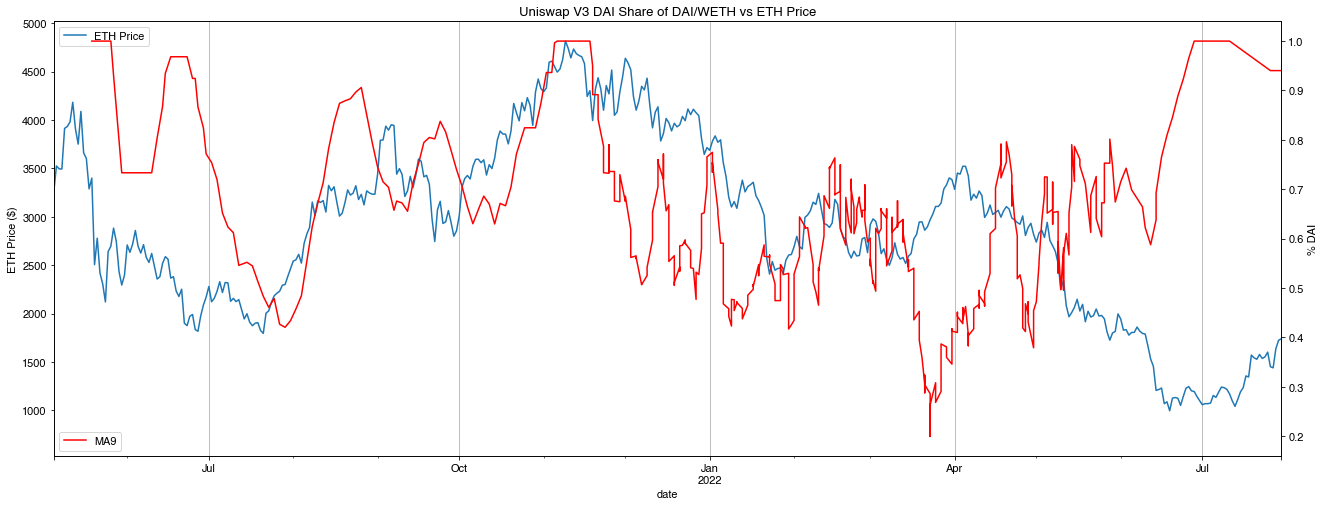

In [230]:
fig , ax = plt.subplots()
eth_concat = eth_df[(eth_df['date']>'2021-01-01')& (eth_df['date']<'2022-07-31')]
eth_concat['date'] = pd.to_datetime(eth_concat['date'])
eth_concat.plot(x='date', y='price', figsize = (22,8), ax=ax)
ax.legend(['ETH Price'], loc = 'upper left')
ax.set_ylabel('ETH Price ($)')
ax2 = ax.twinx()

curr_pool = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='USDC/UST') & 
                   (dex_df['chain']=='Ethereum') & 
                   (dex_df['protocol_version']=='V3')]

curr_pool = curr_pool[(curr_pool['date']>'2021-01-01')& (curr_pool['date']<'2022-07-31')]
#curr_pool = curr_pool.drop_duplicates(subset=['date'], keep = 'first')

curr_pool['date'] = pd.to_datetime(curr_pool['date'])
curr_pool['MA9'] = curr_pool['%1'].rolling(9).mean()
curr_pool.plot(x='date', y='MA9', ax = ax2, color = 'red')
ax2.set_ylabel('% DAI')

ax.xaxis.grid()
ax.set_title('Uniswap V3 DAI Share of DAI/WETH vs ETH Price')

/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/2290644959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_concat['date'] = pd.to_datetime(eth_concat['date'])


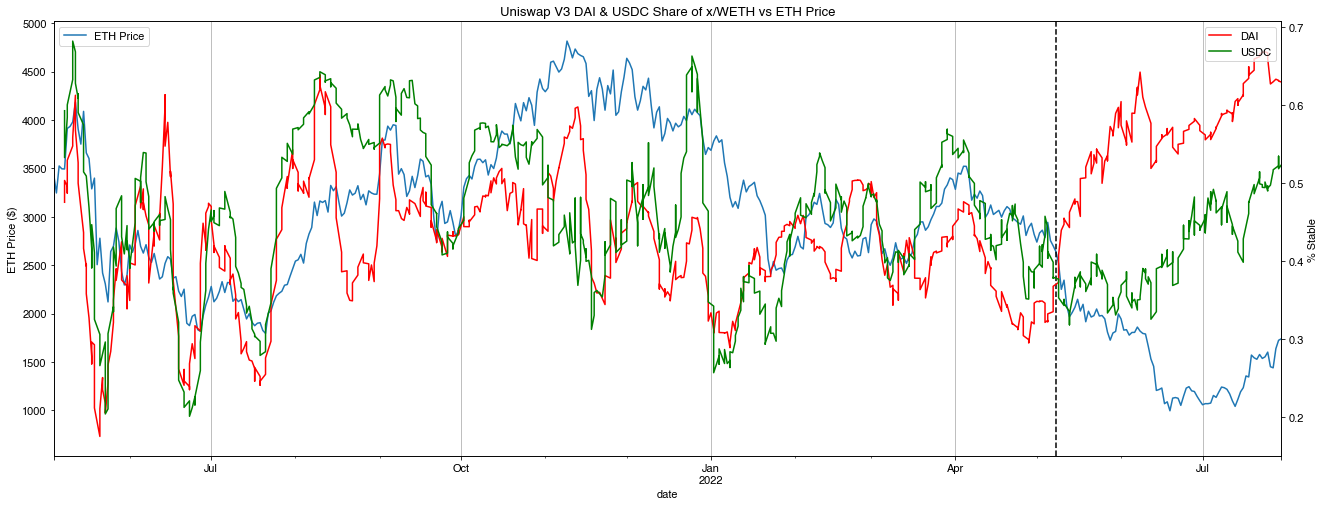

In [231]:
fig , ax = plt.subplots()
eth_concat = eth_df[(eth_df['date']>'2021-01-01')& (eth_df['date']<'2022-07-31')]
eth_concat['date'] = pd.to_datetime(eth_concat['date'])
eth_concat.plot(x='date', y='price', figsize = (22,8), ax=ax)
ax.legend(['ETH Price'], loc = 'upper left')
ax.set_ylabel('ETH Price ($)')
ax2 = ax.twinx()

curr_pool = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='DAI/WETH') & 
                   (dex_df['chain']=='Ethereum') & 
                   (dex_df['protocol_version']=='V3')]

curr_pool1 = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='USDC/WETH') & 
                   (dex_df['chain']=='Ethereum') & 
                   (dex_df['protocol_version']=='V3')]

curr_pool = curr_pool[(curr_pool['date']>'2021-01-01')& (curr_pool['date']<'2022-07-31')]
curr_pool1 = curr_pool1[(curr_pool1['date']>'2021-01-01')& (curr_pool1['date']<'2022-07-31')]
#curr_pool = curr_pool.drop_duplicates(subset=['date'], keep = 'first')

curr_pool['date'] = pd.to_datetime(curr_pool['date'])
curr_pool1['date'] = pd.to_datetime(curr_pool1['date'])

curr_pool['MA9'] = curr_pool['%1'].rolling(9).mean()
curr_pool1['MA9'] = curr_pool1['%1'].rolling(9).mean()

curr_pool.plot(x='date', y='MA9', ax = ax2, color = 'red')
curr_pool1.plot(x='date', y='MA9', ax = ax2, color = 'green', legend = 'USDC')
ax2.set_ylabel('% Stable')
ax2.legend(['DAI','USDC'], loc = 'upper right')

ax.xaxis.grid()
ax.set_title('Uniswap V3 DAI & USDC Share of x/WETH vs ETH Price')
ax.axvline(x = '2022-05-08', color = 'black', linestyle = '--')

/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/3879239626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_concat['date'] = pd.to_datetime(eth_concat['date'])


Text(0.5, 1.0, 'Uniswap V3 DAI Share of DAI/WETH vs ETH Price')

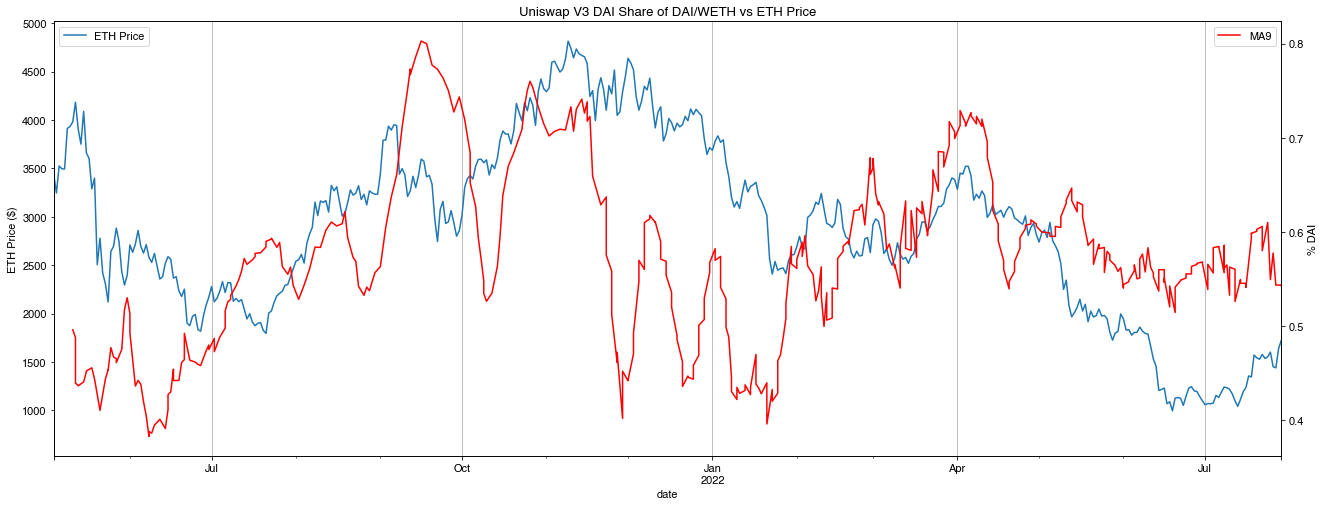

In [232]:
fig , ax = plt.subplots()
eth_concat = eth_df[(eth_df['date']>'2021-01-01')& (eth_df['date']<'2022-07-31')]
eth_concat['date'] = pd.to_datetime(eth_concat['date'])
eth_concat.plot(x='date', y='price', figsize = (22,8), ax=ax)
ax.legend(['ETH Price'], loc = 'upper left')
ax.set_ylabel('ETH Price ($)')
ax2 = ax.twinx()

curr_pool = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='DAI/USDC') & 
                   (dex_df['chain']=='Ethereum') & 
                   (dex_df['protocol_version']=='V3')]

curr_pool = curr_pool[(curr_pool['date']>'2021-01-01')& (curr_pool['date']<'2022-07-31')]
#curr_pool = curr_pool.drop_duplicates(subset=['date'], keep = 'first')

curr_pool['date'] = pd.to_datetime(curr_pool['date'])
curr_pool['MA9'] = curr_pool['%1'].rolling(9).mean()
curr_pool.plot(x='date', y='MA9', ax = ax2, color = 'red')
ax2.set_ylabel('% DAI')

ax.xaxis.grid()
ax.set_title('Uniswap V3 DAI Share of DAI/WETH vs ETH Price')

0.16276229531476397
13.262899371482169


/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/3048298266.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_pool['date'] = pd.to_datetime(curr_pool['date'])


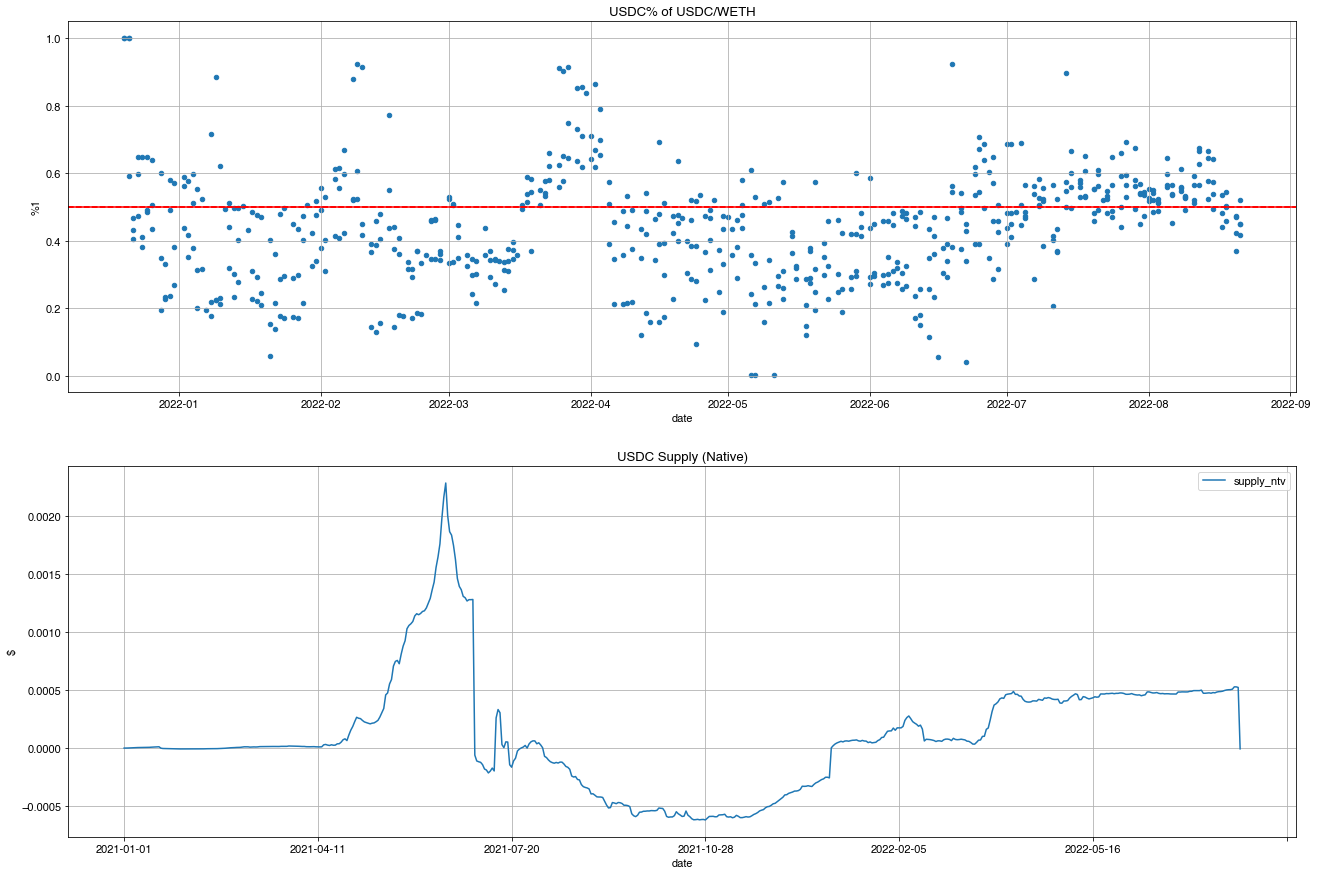

In [233]:
curr_pool = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='USDC/WETH') & 
                   (dex_df['chain']=='Polygon') & 
                   (dex_df['protocol_version']=='V3')]

start_dt = '2021-01-01'
end_dt = '2022-07-31'

curr_pool['date'] = pd.to_datetime(curr_pool['date'])
print(np.std(curr_pool['%1']))
#curr_pool = concat_data(curr_pool, start_dt, end_dt)
#curr_pool['date'] = curr_pool.date.dt.date
#curr_pool = curr_pool.dropna()
#print(curr_pool)

token_1 = curr_pool['token_1'].iloc[50]
token_2 = curr_pool['token_2'].iloc[50]
chain = curr_pool['chain'].iloc[50]

curr_token = stable_df.loc[(stable_df['token']==token_1)
                          & (stable_df['chain']==chain.lower())]
#date_array = pd.date_range('2021-01-01', '2022-07-31')
#date_array = date_array.map(lambda t: t.strftime('%Y-%m-%d'))
#curr_token['date'] = date_array
#curr_token = curr_token.dropna()
curr_token = concat_data(curr_token, start_dt, end_dt)

fig, (ax1, ax2) = plt.subplots(2, figsize = (22,30))

curr_pool.plot.scatter(x = 'date', y= '%1', ax = ax1,  figsize = (22,15), title = (token_1 + "% of "+ token_1 + '/' + token_2))

ax1.axhline(y = 0.5, color = 'r', linestyle = '-')
ax1.axhline(y = 0.5005, color = 'r', linestyle = '--')
ax1.axhline(y = 0.4995, color = 'r', linestyle = '--')
#ax1.axvline(x = datetime(2022,2,1), color = 'g', linestyle = '--')
#ax1.axvline(x = datetime(2022,4,1), color = 'g', linestyle = '--')
ax1.grid()
#start_date = datetime(2021, 3, 2)
#end_date = datetime(2021, 3, 5)
#ax1.set_xlim([start_dt, end_dt])
curr_token.plot(x = 'date', y = 'supply_ntv', figsize = (22,15), ax = ax2, title = token_1 + ' Supply (Native)', ylabel = '$')
ax2.grid()
print(np.mean(curr_pool['error 1']*100))
#ax2.axvline(x = datetime(2022,4,1), color = 'g', linestyle = '--')
#ax2.axvline(x = datetime(2022,2,1), color = 'g', linestyle = '--')
#ax2.axhline(y = 1.5e9, color = 'r', linestyle = '--')

In [234]:
#Slippage Test

variance = 0.005
x = 100000
y = 100000
e = 0.99

a = (y / e) - x
a
#e = (a+x)/y
#a/

#k = 0.5
#x * y = k
#derivative 
#dy/dx(xy) = k
#xy'+x'y = 0
#xy' + y = 0
# y' = -y/x

#yPrime = -y/x
#print(f"For every increment of x, y will change by "+str(yPrime))


1010.1010101010179

In [235]:
def plot_SupplyByUsers(start_dt, end_dt):
    tvl_supply_array = []
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(22,30))
    fig 
    subplots = [ax1,ax2,ax3]

    chains = ['Avalanche','Ethereum','Polygon']
    chain_prices = [avax_df, eth_df, matic_df]
    dfs = []

    for k in range(3):
        price_df = concat_data(chain_prices[k], start_dt, end_dt)
        fix_dates(price_df)
        
        curr_chain=chains[k]
        ax = subplots[k]

        tvl_df = stable_df[(stable_df['chain']==curr_chain.lower())]
        tvl_df = tvl_df[(tvl_df['date'] >= start_dt) & (tvl_df['date'] <= end_dt)]
        tvl_df = tvl_df.groupby(['date'])['Unique Users'].sum().to_frame().abs()
        dfs.append(tvl_df)

        supply_df = stable_df[(stable_df['chain']==curr_chain.lower())]
        supply_df = supply_df[(supply_df['date'] >= start_dt) & (supply_df['date'] <= end_dt)]
        supply_df = supply_df.groupby(['date'])['supply_ntv'].sum().to_frame().abs()
        dfs.append(supply_df)

        tvl_supply = tvl_df
        tvl_supply['supply'] = supply_df.supply_ntv
        tvl_supply['supply/users'] = tvl_df['supply']/tvl_df['Unique Users']
        tvl_supply = tvl_supply.reset_index()
        tvl_supply['date'] = pd.to_datetime(tvl_supply['date'])
        tvl_supply_array.append(tvl_supply)
        
        
        ROLLING_MEAN_LENGTH = 5
        
        ax.plot(tvl_supply['date'],tvl_supply['supply/users'].rolling(9).mean())
        ax.set_title(curr_chain+ ' Supply/Users')
        ax.set_ylabel('supply/users')
        ax.legend(['Supply/Users'],loc = 'upper left')
        
        axtwin = ax.twinx()
        axtwin.plot(tvl_supply['date'],tvl_supply['supply'].rolling(9).mean(), color = 'red')
        axtwin.set_ylabel('Unique Users')
        axtwin.legend(['Unique Users'],loc = 'upper right')

        subplots[k].grid()

    return tvl_supply_array

[          date  Unique Users        supply   supply/users
 0   2021-01-01           0.0  0.000000e+00            NaN
 1   2021-01-02           0.0  0.000000e+00            NaN
 2   2021-01-03           0.0  0.000000e+00            NaN
 3   2021-01-04           0.0  0.000000e+00            NaN
 4   2021-01-05           0.0  0.000000e+00            NaN
 ..         ...           ...           ...            ...
 572 2022-07-27       13199.0  3.470263e+09  262918.602315
 573 2022-07-28       13493.0  3.066535e+09  227268.592494
 574 2022-07-29       13160.0  3.022972e+09  229709.084099
 575 2022-07-30       12096.0  2.975138e+09  245960.506133
 576 2022-07-31       12227.0  6.206288e+08   50758.877891
 
 [577 rows x 4 columns],
           date  Unique Users        supply  supply/users
 0   2021-01-01      138410.0  1.943441e+10  1.404119e+05
 1   2021-01-02      147969.0  1.970729e+10  1.331853e+05
 2   2021-01-03      148298.0  1.978007e+10  1.333806e+05
 3   2021-01-04      155997.0  2.

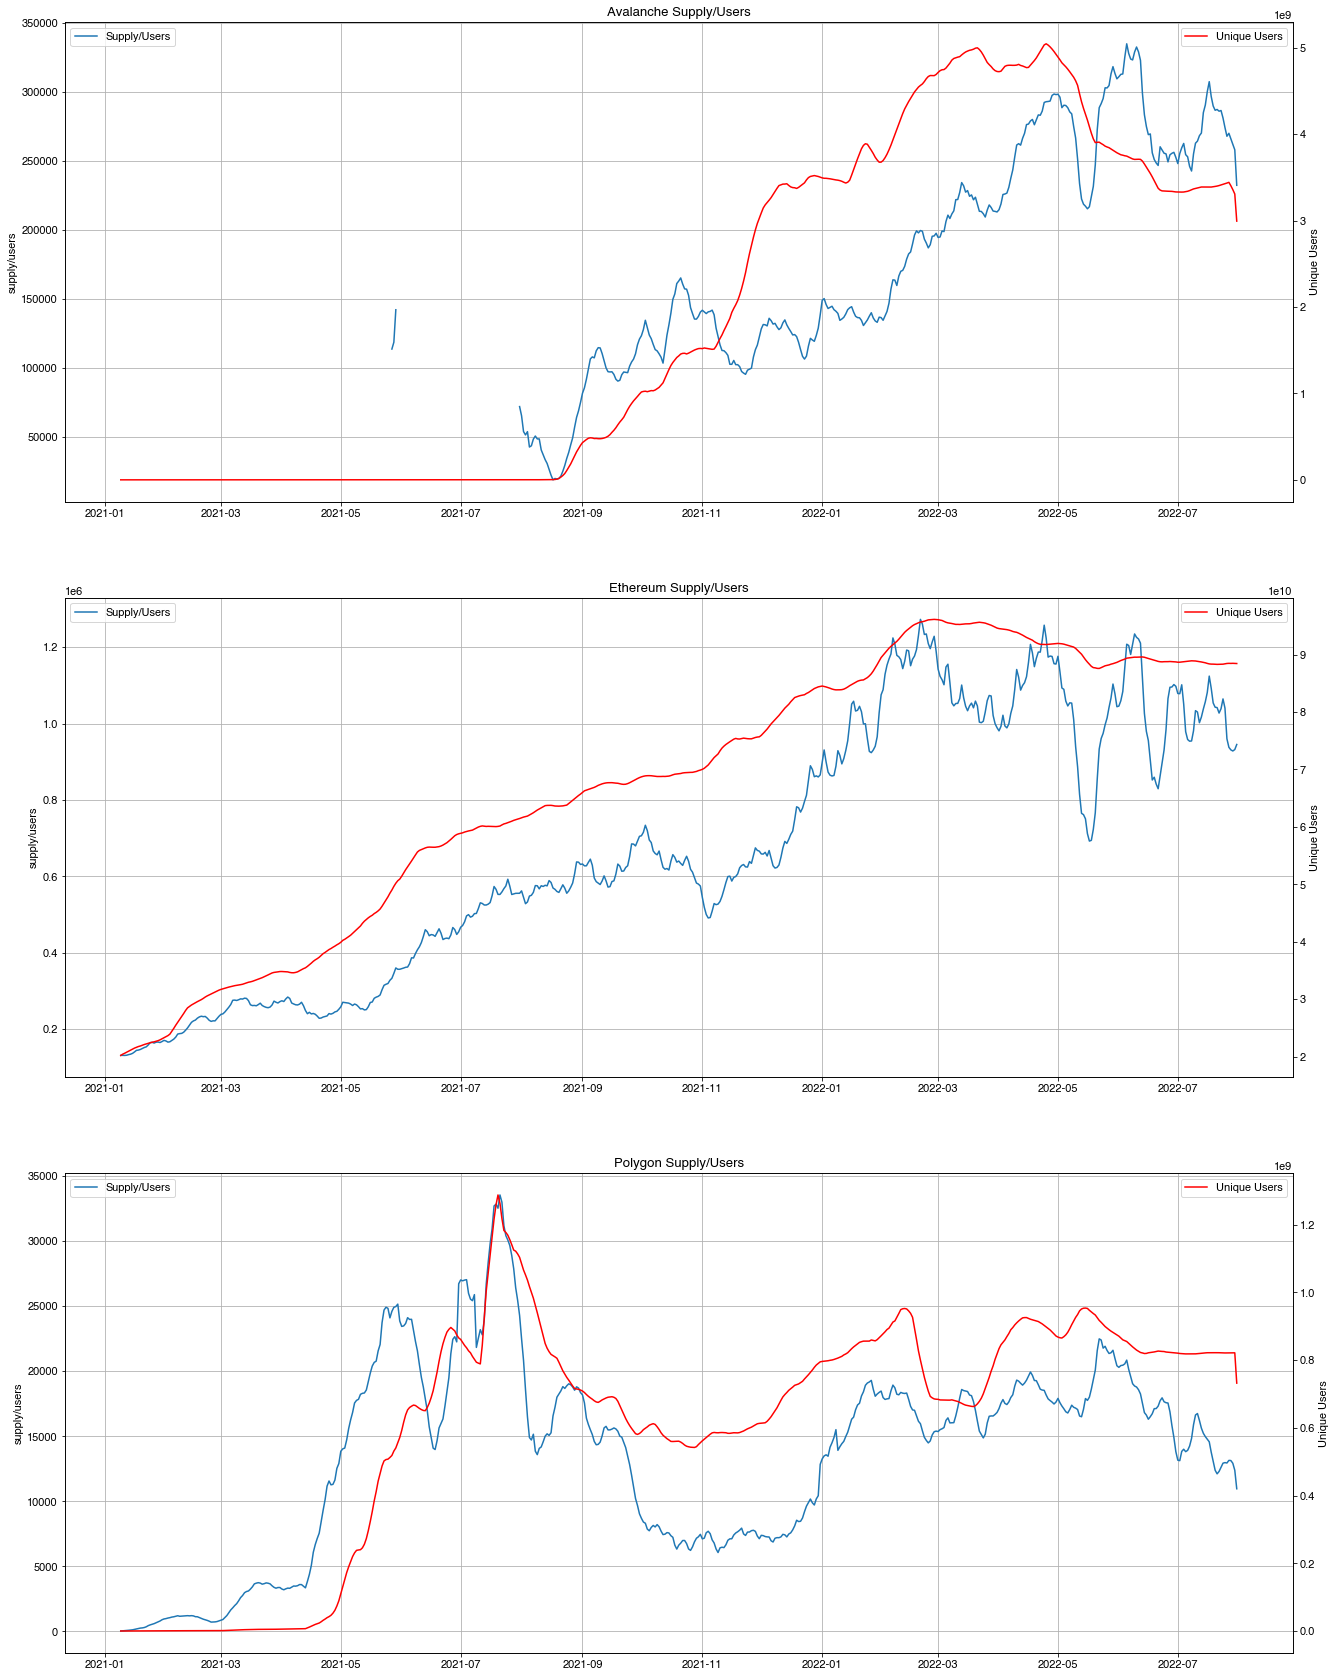

In [236]:
plot_SupplyByUsers('2021-01-01','2022-07-31')

In [283]:
def plot_UsersSupply(start_dt, end_dt):
    tvl_supply_array = []
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(22,30))
    fig 
    subplots = [ax1,ax2,ax3]

    chains = ['Avalanche','Ethereum','Polygon']
    chain_prices = {
        'Avalanche':avax_df, 
        'Ethereum':eth_df, 
        'Polygon':matic_df
                   }
    dfs = []

    for k in range(3):
        #price_df = concat_data(chain_prices[k], start_dt, end_dt)
        #fix_dates(price_df)
        
        curr_chain=chains[k]
        price = chain_prices[curr_chain]
        price['date'] = pd.to_datetime(price['date'])
        price = price[(price['date']>start_dt)& (price['date']<end_dt)]
        ax = subplots[k]

        tvl_df = stable_df[(stable_df['chain']==curr_chain.lower())]
        tvl_df = tvl_df[(tvl_df['date'] >= start_dt) & (tvl_df['date'] <= end_dt)]
        tvl_df = tvl_df.groupby(['date'])['Unique Users'].sum().to_frame().abs()
        dfs.append(tvl_df)

        supply_df = stable_df[(stable_df['chain']==curr_chain.lower())]
        supply_df = supply_df[(supply_df['date'] >= start_dt) & (supply_df['date'] <= end_dt)]
        supply_df = supply_df.groupby(['date'])['supply_ntv'].sum().to_frame().abs()
        dfs.append(supply_df)

        tvl_supply = tvl_df
        tvl_supply['supply'] = supply_df.supply_ntv
        tvl_supply['supply/users'] = tvl_df['supply']/tvl_df['Unique Users']
        tvl_supply = tvl_supply.reset_index()
        tvl_supply['date'] = pd.to_datetime(tvl_supply['date'])
        tvl_supply_array.append(tvl_supply)

        
        
        ROLLING_MEAN_LENGTH = 7
        tvl_supply['14d_change'] = tvl_supply['supply/users'].rolling(5).mean().pct_change(periods=10) 
        
        ax.plot(tvl_supply['date'],tvl_supply['supply/users'].rolling(ROLLING_MEAN_LENGTH).mean())
        ax.set_title(curr_chain+ ' Supply vs Users')
        ax.set_ylabel('supply/users')
        ax.legend(['Supply/Users'],loc = 'upper left')
        
        axtwin = ax.twinx()
        axtwin.plot(price['date'],price['price'].rolling(1).mean(), color = 'red')
        axtwin.set_ylabel('Price ($)')
        axtwin.legend(['Price'],loc = 'upper right')
        
        std = np.std(tvl_supply['14d_change'])
        mean = np.mean(tvl_supply['supply/users'])
        print(mean)
#        ax.axhline(y = mean+std*0.5, color = 'r', linestyle = '--')
#        ax.axhline(y = mean-std*0.5, color = 'r', linestyle = '--')


        subplots[k].grid()

    return tvl_supply_array

192791.46409205577
903747.3680487596
14092.382358354867


[          date  Unique Users        supply   supply/users  14d_change
 0   2021-09-01        4337.0  5.005373e+08  115410.958812         NaN
 1   2021-09-02        4583.0  4.808792e+08  104926.736171         NaN
 2   2021-09-03        4460.0  4.968904e+08  111410.402110         NaN
 3   2021-09-04        3666.0  4.869369e+08  132825.129647         NaN
 4   2021-09-05        3605.0  4.810612e+08  133442.786971         NaN
 ..         ...           ...           ...            ...         ...
 329 2022-07-27       13199.0  3.470263e+09  262918.602315   -0.126917
 330 2022-07-28       13493.0  3.066535e+09  227268.592494   -0.155386
 331 2022-07-29       13160.0  3.022972e+09  229709.084099   -0.147204
 332 2022-07-30       12096.0  2.975138e+09  245960.506133   -0.128165
 333 2022-07-31       12227.0  6.206288e+08   50758.877891   -0.254352
 
 [334 rows x 5 columns],
           date  Unique Users        supply  supply/users  14d_change
 0   2021-09-01      120407.0  6.653687e+10  5.5259

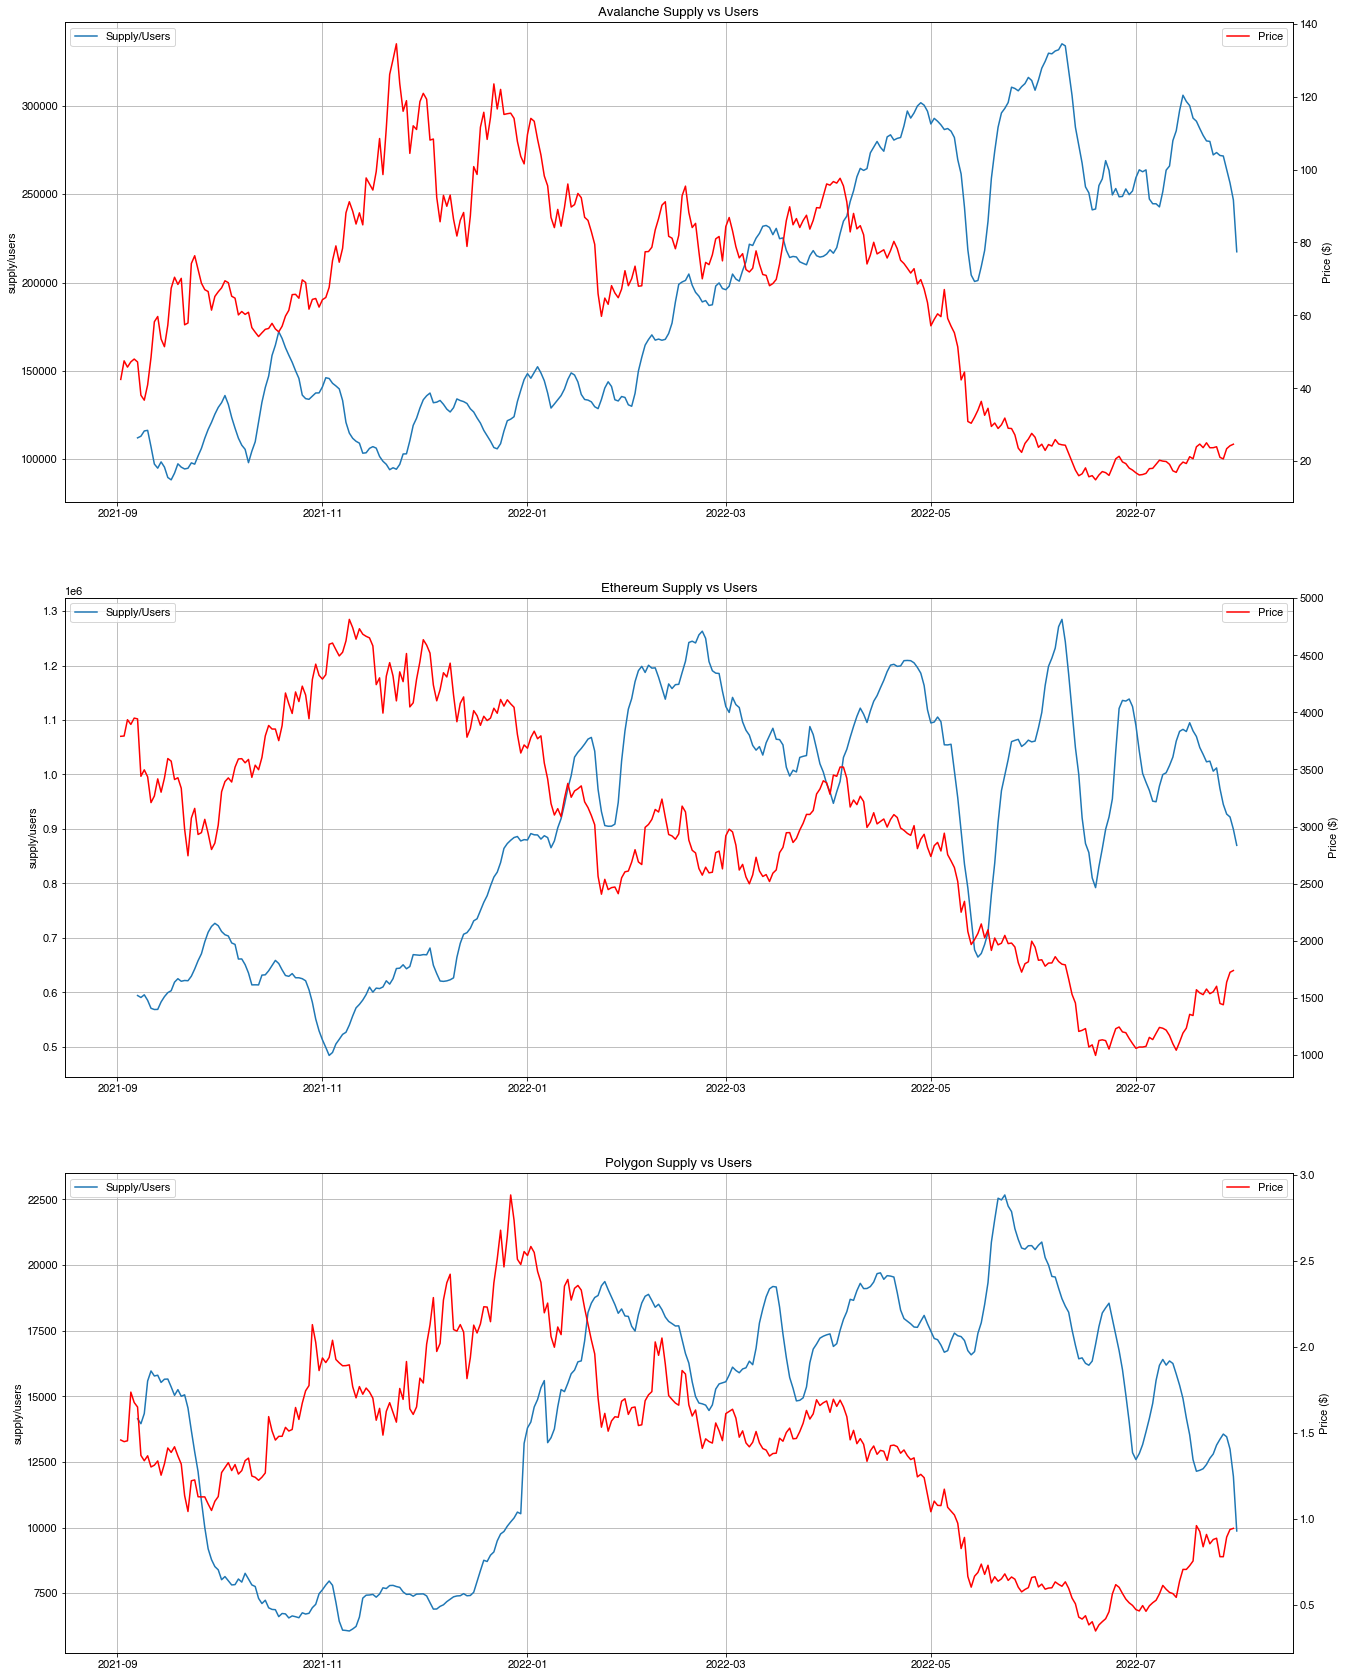

In [285]:
plot_UsersSupply('2021-09-01','2022-07-31')

0.02694851710714551
0.032618479583523395


/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/852027976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_pool['date'] = pd.to_datetime(curr_pool['date'])
/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_18498/852027976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_pool['MA30'] = curr_pool['error 1'].rolling(30).mean()


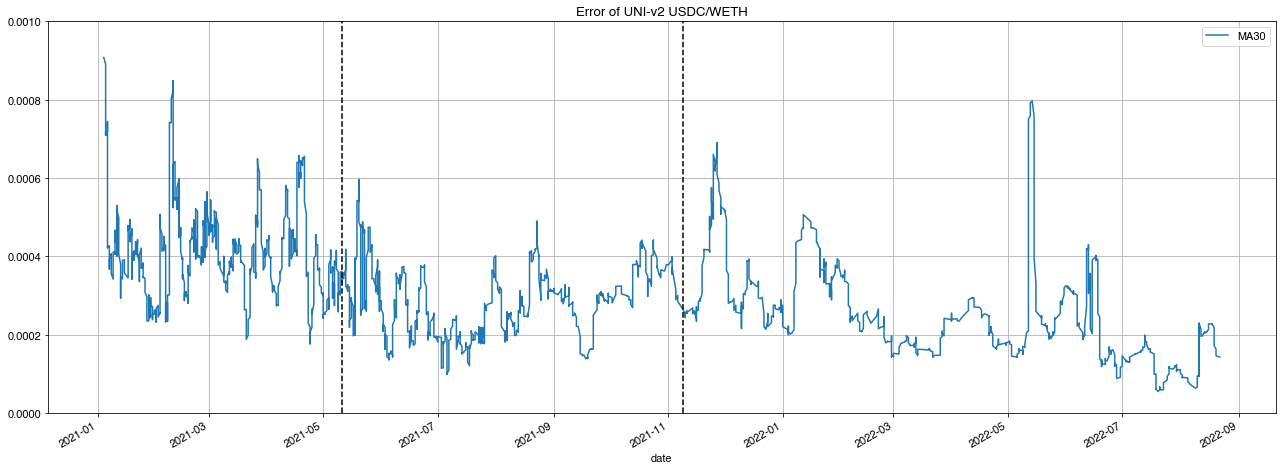

In [239]:
#ERROR IN POOL
curr_pool = dex_df[(dex_df['protocol']=='Uniswap')& 
                   (dex_df['pool_name']=='USDC/WETH') & 
                   (dex_df['chain']=='Ethereum') & 
                   (dex_df['error 1']<0.0025)&
                   (dex_df['%1']>0.4)&
                   (dex_df['protocol_version']=='V2')]
curr_pool['date'] = pd.to_datetime(curr_pool['date'])
curr_pool['MA30'] = curr_pool['error 1'].rolling(30).mean()
#curr_pool = curr_pool[(curr_pool['date']>'2021-01-01')& (curr_pool['date']<'2022-01-01')]
ax1 = curr_pool.plot(x='date', y='MA30', figsize = (22,8), ylim = (0,0.0010))
range_mean = curr_pool[(curr_pool['date']>'2021-05-11')& (curr_pool['date']<'2021-05-18')]
mean = np.mean(range_mean['error 1'])
overall_error = np.mean(curr_pool['error 1'])
ax1.axvline(x = datetime(2021,5,11), color = 'black', linestyle = '--')
ax1.axvline(x = datetime(2021,11,9), color = 'black', linestyle = '--')
ax1.set_title('Error of UNI-v2 USDC/WETH')
ax1.grid()
print(mean*100)
print(overall_error*100)